# Healthcare Data Challenge

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

## Section 1: Data Preparation

In [2]:
bill_amt = pd.read_csv('bill_amount.csv')
bill_id = pd.read_csv('bill_id.csv')
clinical_data = pd.read_csv('clinical_data.csv')
demographics = pd.read_csv('demographics.csv')

## Merging Bill Dataframes

In [3]:
bill_amt.head()

bill_id       amount
0    40315104  1552.634830
1  2660045161  1032.011951
2  1148334643  6469.605351
3  3818426276   755.965425
4  9833541918   897.347816

In [4]:
bill_amt.isnull().sum()

bill_id    0
amount     0
dtype: int64

In [5]:
bill_amt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bill_id  13600 non-null  int64  
 1   amount   13600 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 212.6 KB


In [6]:
bill_amt[bill_amt.duplicated()]

Empty DataFrame
Columns: [bill_id, amount]
Index: []

In [7]:
bill_id.head()

bill_id                        patient_id date_of_admission
0  7968360812  1d21f2be18683991eb93d182d6b2d220        2011-01-01
1  6180579974  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01
2  7512568183  1d21f2be18683991eb93d182d6b2d220        2011-01-01
3  3762633379  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01
4  7654730355  1d21f2be18683991eb93d182d6b2d220        2011-01-01

In [8]:
bill_id.isnull().sum()

bill_id              0
patient_id           0
date_of_admission    0
dtype: int64

In [9]:
bill_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   bill_id            13600 non-null  int64 
 1   patient_id         13600 non-null  object
 2   date_of_admission  13600 non-null  object
dtypes: int64(1), object(2)
memory usage: 318.9+ KB


In [10]:
bill_id[bill_id.duplicated()]

Empty DataFrame
Columns: [bill_id, patient_id, date_of_admission]
Index: []

- There are no null values in bill data
- We will merge the two dataframes based on bill_id

In [11]:
bill = pd.merge(bill_amt, bill_id, on='bill_id', how='inner')

In [12]:
bill.head()

bill_id       amount                        patient_id date_of_admission
0    40315104  1552.634830  96a76ec5bbcb1d1562c40b9b972e356d        2012-10-22
1  2660045161  1032.011951  796de06efdad342d3f3a379dff0bd63c        2014-09-28
2  1148334643  6469.605351  1ce104904e9160cf3cfdb3c45b9ce4ff        2014-01-16
3  3818426276   755.965425  afdfe7216d84e13708a19cbca288379a        2013-01-22
4  9833541918   897.347816  b9a0c119dc07e07f88281964f3a4869f        2011-04-22

In [13]:
bill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13600 entries, 0 to 13599
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_id            13600 non-null  int64  
 1   amount             13600 non-null  float64
 2   patient_id         13600 non-null  object 
 3   date_of_admission  13600 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 531.2+ KB


In [14]:
cat_cols = bill.select_dtypes(include=['object']).columns

for column in cat_cols:
    print("For column:", column)
    print(bill[column].value_counts())
    print('-'*50)

For column: patient_id
4e46fddfa404b306809c350aecbf0f6a    16
af713a949eda293f348bf51a058e48a1    12
cf835526e33d00afa016ac898582038c    12
64a531972193ccf232cc47597ddb85ed    12
feb52392f4d58a02254cbd0ba634312f    12
                                    ..
df98b6d4bc19418810420e19ba8d900d     4
7c2cf7e1e3d3862aa226e81387572b44     4
34a05abce831dc539d0a06cc18bb235e     4
49f1ab45d13104df4931583df9482acb     4
c607942a9bebf9c61daf2c0da499ddf5     4
Name: patient_id, Length: 3000, dtype: int64
--------------------------------------------------
For column: date_of_admission
2014-05-24    36
2012-10-22    28
2012-06-26    28
2011-01-18    28
2015-08-21    28
              ..
2014-07-11     4
2013-10-08     4
2012-12-06     4
2015-08-28     4
2015-05-13     4
Name: date_of_admission, Length: 1450, dtype: int64
--------------------------------------------------


- Each patient has a minimum of 4 bills to a maximum of 16 bills
- There are a minimum of 4 admissions per day up to 36

## Merging Clinical Data with Bill Data

In [15]:
clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3400 non-null   object 
 1   date_of_admission   3400 non-null   object 
 2   date_of_discharge   3400 non-null   object 
 3   medical_history_1   3400 non-null   int64  
 4   medical_history_2   3167 non-null   float64
 5   medical_history_3   3400 non-null   object 
 6   medical_history_4   3400 non-null   int64  
 7   medical_history_5   3096 non-null   float64
 8   medical_history_6   3400 non-null   int64  
 9   medical_history_7   3400 non-null   int64  
 10  preop_medication_1  3400 non-null   int64  
 11  preop_medication_2  3400 non-null   int64  
 12  preop_medication_3  3400 non-null   int64  
 13  preop_medication_4  3400 non-null   int64  
 14  preop_medication_5  3400 non-null   int64  
 15  preop_medication_6  3400 non-null   int64  
 16  sympto

In [16]:
clinical_data['patient_id'] = clinical_data['id']

In [17]:
clinical_data[clinical_data['id']=='4e46fddfa404b306809c350aecbf0f6a']

id date_of_admission date_of_discharge  \
634   4e46fddfa404b306809c350aecbf0f6a        2011-11-23        2011-12-05   
1356  4e46fddfa404b306809c350aecbf0f6a        2013-01-06        2013-01-17   
1391  4e46fddfa404b306809c350aecbf0f6a        2013-01-23        2013-02-02   
1823  4e46fddfa404b306809c350aecbf0f6a        2013-09-16        2013-09-27   

      medical_history_1  medical_history_2 medical_history_3  \
634                   1                1.0                 0   
1356                  0                0.0                 0   
1391                  0                0.0                 0   
1823                  1                1.0                No   

      medical_history_4  medical_history_5  medical_history_6  \
634                   0                0.0                  0   
1356                  0                0.0                  0   
1391                  0                0.0                  0   
1823                  0                0.0                  1   

      medical_history_7  preop_medication_1  preop_medication_2  \
634                   0                   1                   1   
1356                  0                   0                   1   
1391                  1                   0                   0   
1823                  0                   0                   1   

      preop_medication_3  preop_medication_4  preop_medication_5  \
634                    1                   0                   0   
1356                   1                   1                   1   
1391                   1                   1                   0   
1823                   1                   0                   1   

      preop_medication_6  symptom_1  symptom_2  symptom_3  symptom_4  \
634                    1          1          0          1          1   
1356                   1          1          0          1          0   
1391                   1          0          0          0          0   
1823                   0          1          1          0          0   

      symptom_5  lab_result_1  lab_result_2  lab_result_3  weight  height  \
634           0          16.1          25.5         111.0    71.4   166.0   
1356          0          14.1          24.1         103.0    71.4   166.0   
1391          0          13.0          27.0          91.0    70.4   166.0   
1823          1          11.7          22.6          84.0    70.4   166.0   

                            patient_id  
634   4e46fddfa404b306809c350aecbf0f6a  
1356  4e46fddfa404b306809c350aecbf0f6a  
1391  4e46fddfa404b306809c350aecbf0f6a  
1823  4e46fddfa404b306809c350aecbf0f6a

In [18]:
bill[bill['patient_id']=='4e46fddfa404b306809c350aecbf0f6a']

bill_id        amount                        patient_id  \
203     839597397   6132.750887  4e46fddfa404b306809c350aecbf0f6a   
354    1658432711    868.435533  4e46fddfa404b306809c350aecbf0f6a   
732     543243535    769.098299  4e46fddfa404b306809c350aecbf0f6a   
1892   4538054359   2053.144782  4e46fddfa404b306809c350aecbf0f6a   
2404    136013293    746.477367  4e46fddfa404b306809c350aecbf0f6a   
4467    118453328   1557.500102  4e46fddfa404b306809c350aecbf0f6a   
4605   3680165171    592.684082  4e46fddfa404b306809c350aecbf0f6a   
8156   7875201153    797.989644  4e46fddfa404b306809c350aecbf0f6a   
8246   3619424812    975.982803  4e46fddfa404b306809c350aecbf0f6a   
9303    483325687   1487.709021  4e46fddfa404b306809c350aecbf0f6a   
9969   9600908611   1269.881609  4e46fddfa404b306809c350aecbf0f6a   
11270  5694828317   9242.658865  4e46fddfa404b306809c350aecbf0f6a   
11953  1288390292   7675.021417  4e46fddfa404b306809c350aecbf0f6a   
12726  1808393173  10361.862067  4e46fddfa404b306809c350aecbf0f6a   
13037  9525586787   1354.232142  4e46fddfa404b306809c350aecbf0f6a   
13554  5045123685  16321.969490  4e46fddfa404b306809c350aecbf0f6a   

      date_of_admission  
203          2011-11-23  
354          2011-11-23  
732          2013-01-06  
1892         2013-01-23  
2404         2013-01-23  
4467         2013-01-23  
4605         2013-01-23  
8156         2013-01-06  
8246         2013-09-16  
9303         2013-09-16  
9969         2013-01-06  
11270        2013-09-16  
11953        2013-01-06  
12726        2011-11-23  
13037        2011-11-23  
13554        2013-09-16

- There are multiple records for bill_ids per day per patient_id
- We will sum the total bill for each day in bill before merging it with clinical_data

In [19]:
bill_grouped = bill.groupby(['patient_id','date_of_admission']).sum()

In [20]:
data = pd.merge(clinical_data, bill_grouped, on=['patient_id', 'date_of_admission'])

In [21]:
data.head()

id date_of_admission date_of_discharge  \
0  1d21f2be18683991eb93d182d6b2d220        2011-01-01        2011-01-11   
1  62bdca0b95d97e99e1c712048fb9fd09        2011-01-01        2011-01-11   
2  c85cf97bc6307ded0dd4fef8bad2fa09        2011-01-02        2011-01-13   
3  e0397dd72caf4552c5babebd3d61736c        2011-01-02        2011-01-14   
4  94ade3cd5f66f4584902554dff170a29        2011-01-08        2011-01-16   

   medical_history_1  medical_history_2 medical_history_3  medical_history_4  \
0                  0                1.0                 0                  0   
1                  0                0.0                 0                  0   
2                  0                0.0                 0                  0   
3                  0                1.0                No                  0   
4                  0                0.0                No                  0   

   medical_history_5  medical_history_6  medical_history_7  \
0                0.0                  0                  0   
1                0.0                  0                  0   
2                0.0                  0                  0   
3                0.0                  1                  1   
4                0.0                  1                  1   

   preop_medication_1  preop_medication_2  preop_medication_3  \
0                   1                   0                   1   
1                   0                   1                   1   
2                   0                   1                   1   
3                   1                   0                   1   
4                   0                   0                   0   

   preop_medication_4  preop_medication_5  preop_medication_6  symptom_1  \
0                   0                   0                   1          0   
1                   1                   1                   0          0   
2                   1                   1                   1          1   
3                   0                   0                   1          1   
4                   0                   1                   0          0   

   symptom_2  symptom_3  symptom_4  symptom_5  lab_result_1  lab_result_2  \
0          0          0          1          1          13.2          30.9   
1          0          1          1          1          13.8          22.6   
2          1          1          1          0          11.2          26.2   
3          1          1          1          1          13.3          28.4   
4          1          0          1          0          12.0          27.8   

   lab_result_3  weight  height                        patient_id  \
0         123.0    71.3   161.0  1d21f2be18683991eb93d182d6b2d220   
1          89.0    78.4   160.0  62bdca0b95d97e99e1c712048fb9fd09   
2         100.0    72.0   151.0  c85cf97bc6307ded0dd4fef8bad2fa09   
3          76.0    64.4   152.0  e0397dd72caf4552c5babebd3d61736c   
4          87.0    55.6   160.0  94ade3cd5f66f4584902554dff170a29   

       bill_id        amount  
0  24827855413  15405.418665  
1  11347207842  23303.000924  
2  13773999119  16813.123088  
3  10140865493  27994.878530  
4  27112385167  10707.950907

In [22]:
data[data.duplicated()]

Empty DataFrame
Columns: [id, date_of_admission, date_of_discharge, medical_history_1, medical_history_2, medical_history_3, medical_history_4, medical_history_5, medical_history_6, medical_history_7, preop_medication_1, preop_medication_2, preop_medication_3, preop_medication_4, preop_medication_5, preop_medication_6, symptom_1, symptom_2, symptom_3, symptom_4, symptom_5, lab_result_1, lab_result_2, lab_result_3, weight, height, patient_id, bill_id, amount]
Index: []

In [23]:
data.isnull().sum()

id                      0
date_of_admission       0
date_of_discharge       0
medical_history_1       0
medical_history_2     233
medical_history_3       0
medical_history_4       0
medical_history_5     304
medical_history_6       0
medical_history_7       0
preop_medication_1      0
preop_medication_2      0
preop_medication_3      0
preop_medication_4      0
preop_medication_5      0
preop_medication_6      0
symptom_1               0
symptom_2               0
symptom_3               0
symptom_4               0
symptom_5               0
lab_result_1            0
lab_result_2            0
lab_result_3            0
weight                  0
height                  0
patient_id              0
bill_id                 0
amount                  0
dtype: int64

- Null values in medical_history_2 and medical_history_5
- We will remove these from the dataset instead of imputing values

In [24]:
data = data[data["medical_history_2"].notna()]
data = data[data["medical_history_5"].notna()]

In [25]:
data.isnull().sum()

id                    0
date_of_admission     0
date_of_discharge     0
medical_history_1     0
medical_history_2     0
medical_history_3     0
medical_history_4     0
medical_history_5     0
medical_history_6     0
medical_history_7     0
preop_medication_1    0
preop_medication_2    0
preop_medication_3    0
preop_medication_4    0
preop_medication_5    0
preop_medication_6    0
symptom_1             0
symptom_2             0
symptom_3             0
symptom_4             0
symptom_5             0
lab_result_1          0
lab_result_2          0
lab_result_3          0
weight                0
height                0
patient_id            0
bill_id               0
amount                0
dtype: int64

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 0 to 3397
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2898 non-null   object 
 1   date_of_admission   2898 non-null   object 
 2   date_of_discharge   2898 non-null   object 
 3   medical_history_1   2898 non-null   int64  
 4   medical_history_2   2898 non-null   float64
 5   medical_history_3   2898 non-null   object 
 6   medical_history_4   2898 non-null   int64  
 7   medical_history_5   2898 non-null   float64
 8   medical_history_6   2898 non-null   int64  
 9   medical_history_7   2898 non-null   int64  
 10  preop_medication_1  2898 non-null   int64  
 11  preop_medication_2  2898 non-null   int64  
 12  preop_medication_3  2898 non-null   int64  
 13  preop_medication_4  2898 non-null   int64  
 14  preop_medication_5  2898 non-null   int64  
 15  preop_medication_6  2898 non-null   int64  
 16  sympto

In [27]:
data.describe(include=['object'])

id date_of_admission date_of_discharge  \
count                               2898              2898              2898   
unique                              2608              1367              1443   
top     4e46fddfa404b306809c350aecbf0f6a        2014-05-24        2011-10-23   
freq                                   4                 8                 8   

       medical_history_3                        patient_id  
count               2898                              2898  
unique                 4                              2608  
top                    0  4e46fddfa404b306809c350aecbf0f6a  
freq                1862                                 4

## Merging Data with Demographics

In [28]:
demographics.head()

patient_id  gender     race    resident_status  \
0  fa2d818b2261e44e30628ad1ac9cc72c  Female   Indian        Singaporean   
1  5b6477c5de78d0b138e3b0c18e21d0ae       f  Chinese  Singapore citizen   
2  320aa16c61937447fd6631bf635e7fde    Male  Chinese  Singapore citizen   
3  c7f3881684045e6c49020481020fae36    Male    Malay  Singapore citizen   
4  541ad077cb4a0e64cc422673afe28aef       m  Chinese        Singaporean   

  date_of_birth  
0    1971-05-14  
1    1976-02-18  
2    1982-07-03  
3    1947-06-15  
4    1970-12-12

In [29]:
data = pd.merge(demographics, data, on=['patient_id'])

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 0 to 2897
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2898 non-null   object 
 1   gender              2898 non-null   object 
 2   race                2898 non-null   object 
 3   resident_status     2898 non-null   object 
 4   date_of_birth       2898 non-null   object 
 5   id                  2898 non-null   object 
 6   date_of_admission   2898 non-null   object 
 7   date_of_discharge   2898 non-null   object 
 8   medical_history_1   2898 non-null   int64  
 9   medical_history_2   2898 non-null   float64
 10  medical_history_3   2898 non-null   object 
 11  medical_history_4   2898 non-null   int64  
 12  medical_history_5   2898 non-null   float64
 13  medical_history_6   2898 non-null   int64  
 14  medical_history_7   2898 non-null   int64  
 15  preop_medication_1  2898 non-null   int64  
 16  preop_

In [31]:
data.isnull().sum()

patient_id            0
gender                0
race                  0
resident_status       0
date_of_birth         0
id                    0
date_of_admission     0
date_of_discharge     0
medical_history_1     0
medical_history_2     0
medical_history_3     0
medical_history_4     0
medical_history_5     0
medical_history_6     0
medical_history_7     0
preop_medication_1    0
preop_medication_2    0
preop_medication_3    0
preop_medication_4    0
preop_medication_5    0
preop_medication_6    0
symptom_1             0
symptom_2             0
symptom_3             0
symptom_4             0
symptom_5             0
lab_result_1          0
lab_result_2          0
lab_result_3          0
weight                0
height                0
bill_id               0
amount                0
dtype: int64

In [32]:
data.describe(include=['object'])

patient_id  gender     race resident_status  \
count                               2898    2898     2898            2898   
unique                              2608       4        6               4   
top     4e46fddfa404b306809c350aecbf0f6a  Female  Chinese     Singaporean   
freq                                   4    1351     1544            1725   

       date_of_birth                                id date_of_admission  \
count           2898                              2898              2898   
unique          2406                              2608              1367   
top       1941-01-27  4e46fddfa404b306809c350aecbf0f6a        2014-05-24   
freq               4                                 4                 8   

       date_of_discharge medical_history_3  
count               2898              2898  
unique              1443                 4  
top           2011-10-23                 0  
freq                   8              1862

In [33]:
data = data.drop(['id', 'bill_id', 'patient_id'], axis=1)

In [34]:
cat_cols = data.select_dtypes(include=['object']).columns

for column in cat_cols:
    print("For column:", column)
    print(data[column].value_counts())
    print('-'*50)

For column: gender
Female    1351
Male      1278
m          176
f           93
Name: gender, dtype: int64
--------------------------------------------------
For column: race
Chinese    1544
Malay       598
chinese     311
Indian      202
Others      150
India        93
Name: race, dtype: int64
--------------------------------------------------
For column: resident_status
Singaporean          1725
Singapore citizen     590
PR                    445
Foreigner             138
Name: resident_status, dtype: int64
--------------------------------------------------
For column: date_of_birth
1941-01-27    4
1975-08-20    4
1981-11-14    4
1973-05-25    4
1981-09-27    4
             ..
1954-07-06    1
1949-03-19    1
1980-07-03    1
1948-07-11    1
1986-09-04    1
Name: date_of_birth, Length: 2406, dtype: int64
--------------------------------------------------
For column: date_of_admission
2014-05-24    8
2012-06-26    7
2012-10-14    7
2011-01-18    7
2015-08-21    7
             ..
2014-08-

In [35]:
data["gender"].replace({"m": "Male", "f": "Female"}, inplace=True)
data["race"].replace({"chinese": "Chinese", "India": "Indian"}, inplace=True)
data["resident_status"].replace({"Singapore citizen": "Singaporean"}, inplace=True)
data["medical_history_3"].replace({"0": 0, "1": 1, "No": 0, "Yes": 1}, inplace=True)

In [36]:
cat_cols = data.select_dtypes(include=['object']).columns

for column in cat_cols:
    print("For column:", column)
    print(data[column].value_counts())
    print('-'*50)

For column: gender
Male      1454
Female    1444
Name: gender, dtype: int64
--------------------------------------------------
For column: race
Chinese    1855
Malay       598
Indian      295
Others      150
Name: race, dtype: int64
--------------------------------------------------
For column: resident_status
Singaporean    2315
PR              445
Foreigner       138
Name: resident_status, dtype: int64
--------------------------------------------------
For column: date_of_birth
1941-01-27    4
1975-08-20    4
1981-11-14    4
1973-05-25    4
1981-09-27    4
             ..
1954-07-06    1
1949-03-19    1
1980-07-03    1
1948-07-11    1
1986-09-04    1
Name: date_of_birth, Length: 2406, dtype: int64
--------------------------------------------------
For column: date_of_admission
2014-05-24    8
2012-06-26    7
2012-10-14    7
2011-01-18    7
2015-08-21    7
             ..
2014-08-14    1
2012-10-16    1
2014-08-25    1
2013-05-08    1
2015-06-19    1
Name: date_of_admission, Length: 1

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 0 to 2897
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              2898 non-null   object 
 1   race                2898 non-null   object 
 2   resident_status     2898 non-null   object 
 3   date_of_birth       2898 non-null   object 
 4   date_of_admission   2898 non-null   object 
 5   date_of_discharge   2898 non-null   object 
 6   medical_history_1   2898 non-null   int64  
 7   medical_history_2   2898 non-null   float64
 8   medical_history_3   2898 non-null   int64  
 9   medical_history_4   2898 non-null   int64  
 10  medical_history_5   2898 non-null   float64
 11  medical_history_6   2898 non-null   int64  
 12  medical_history_7   2898 non-null   int64  
 13  preop_medication_1  2898 non-null   int64  
 14  preop_medication_2  2898 non-null   int64  
 15  preop_medication_3  2898 non-null   int64  
 16  preop_

In [38]:
from datetime import datetime

data.date_of_birth = pd.to_datetime(data.date_of_birth, infer_datetime_format=True)
data.date_of_admission = pd.to_datetime(data.date_of_admission, infer_datetime_format=True)
data.date_of_discharge = pd.to_datetime(data.date_of_discharge, infer_datetime_format=True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2898 entries, 0 to 2897
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   gender              2898 non-null   object        
 1   race                2898 non-null   object        
 2   resident_status     2898 non-null   object        
 3   date_of_birth       2898 non-null   datetime64[ns]
 4   date_of_admission   2898 non-null   datetime64[ns]
 5   date_of_discharge   2898 non-null   datetime64[ns]
 6   medical_history_1   2898 non-null   int64         
 7   medical_history_2   2898 non-null   float64       
 8   medical_history_3   2898 non-null   int64         
 9   medical_history_4   2898 non-null   int64         
 10  medical_history_5   2898 non-null   float64       
 11  medical_history_6   2898 non-null   int64         
 12  medical_history_7   2898 non-null   int64         
 13  preop_medication_1  2898 non-null   int64       

In [40]:
data.head()

gender     race resident_status date_of_birth date_of_admission  \
0  Female   Indian     Singaporean    1971-05-14        2014-09-20   
1    Male  Chinese     Singaporean    1982-07-03        2011-03-10   
2    Male    Malay     Singaporean    1947-06-15        2015-10-28   
3    Male  Chinese     Singaporean    1970-12-12        2011-06-02   
4    Male    Malay     Singaporean    1975-09-14        2012-03-06   

  date_of_discharge  medical_history_1  medical_history_2  medical_history_3  \
0        2014-10-04                  0                0.0                  0   
1        2011-03-20                  0                0.0                  0   
2        2015-11-10                  0                1.0                  0   
3        2011-06-13                  0                0.0                  0   
4        2012-03-18                  0                0.0                  0   

   medical_history_4  medical_history_5  medical_history_6  medical_history_7  \
0                  0                0.0                  0                  1   
1                  0                0.0                  1                  0   
2                  0                0.0                  0                  0   
3                  0                0.0                  0                  0   
4                  0                1.0                  0                  0   

   preop_medication_1  preop_medication_2  preop_medication_3  \
0                   1                   0                   1   
1                   0                   1                   1   
2                   0                   1                   0   
3                   1                   1                   1   
4                   1                   1                   1   

   preop_medication_4  preop_medication_5  preop_medication_6  symptom_1  \
0                   0                   1                   1          1   
1                   1                   1                   0          0   
2                   0                   1                   1          1   
3                   0                   1                   1          1   
4                   1                   1                   1          1   

   symptom_2  symptom_3  symptom_4  symptom_5  lab_result_1  lab_result_2  \
0          1          0          0          1          14.2          27.0   
1          0          1          1          1          14.4          26.6   
2          1          1          1          1          14.9          26.7   
3          1          1          1          1          14.1          27.3   
4          1          0          1          0          14.4          27.3   

   lab_result_3  weight  height        amount  
0          81.0    68.1   161.0  19564.166266  
1          92.0    69.7   175.0  14435.913476  
2          97.0    96.9   180.0  45452.313094  
3          98.0    91.6   166.0  22511.346126  
4         107.0    90.1   173.0  17995.220652

In [41]:
data['days_admitted'] = data['date_of_discharge'] - data['date_of_admission'] 
data['age'] = data['date_of_admission'] - data['date_of_birth'] 
data['days_admitted'] = data['days_admitted'].dt.days.astype('int16')
data['age'] = data['age'].dt.days.astype('int16')

In [42]:
data = data.drop(['date_of_discharge', 'date_of_admission', 'date_of_birth'], axis=1)
# data = pd.get_dummies(data, drop_first=True)
data.head()

gender     race resident_status  medical_history_1  medical_history_2  \
0  Female   Indian     Singaporean                  0                0.0   
1    Male  Chinese     Singaporean                  0                0.0   
2    Male    Malay     Singaporean                  0                1.0   
3    Male  Chinese     Singaporean                  0                0.0   
4    Male    Malay     Singaporean                  0                0.0   

   medical_history_3  medical_history_4  medical_history_5  medical_history_6  \
0                  0                  0                0.0                  0   
1                  0                  0                0.0                  1   
2                  0                  0                0.0                  0   
3                  0                  0                0.0                  0   
4                  0                  0                1.0                  0   

   medical_history_7  preop_medication_1  preop_medication_2  \
0                  1                   1                   0   
1                  0                   0                   1   
2                  0                   0                   1   
3                  0                   1                   1   
4                  0                   1                   1   

   preop_medication_3  preop_medication_4  preop_medication_5  \
0                   1                   0                   1   
1                   1                   1                   1   
2                   0                   0                   1   
3                   1                   0                   1   
4                   1                   1                   1   

   preop_medication_6  symptom_1  symptom_2  symptom_3  symptom_4  symptom_5  \
0                   1          1          1          0          0          1   
1                   0          0          0          1          1          1   
2                   1          1          1          1          1          1   
3                   1          1          1          1          1          1   
4                   1          1          1          0          1          0   

   lab_result_1  lab_result_2  lab_result_3  weight  height        amount  \
0          14.2          27.0          81.0    68.1   161.0  19564.166266   
1          14.4          26.6          92.0    69.7   175.0  14435.913476   
2          14.9          26.7          97.0    96.9   180.0  45452.313094   
3          14.1          27.3          98.0    91.6   166.0  22511.346126   
4          14.4          27.3         107.0    90.1   173.0  17995.220652   

   days_admitted    age  
0             14  15835  
1             10  10477  
2             13  24972  
3             11  14782  
4             12  13323

## Section 2: Exploratory Data Analysis

In [43]:
data.describe(include=['object'])

gender     race resident_status
count    2898     2898            2898
unique      2        4               3
top      Male  Chinese     Singaporean
freq     1454     1855            2315

## Univariate Analysis

In [44]:
def histogram_boxplot(feature, figsize=(15,10), bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={"height_ratios": (.25,.75)}, figsize=figsize)
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet')
    sns.distplot(feature, ax=ax_hist2, bins=bins, color ='blue')
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--')
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-')

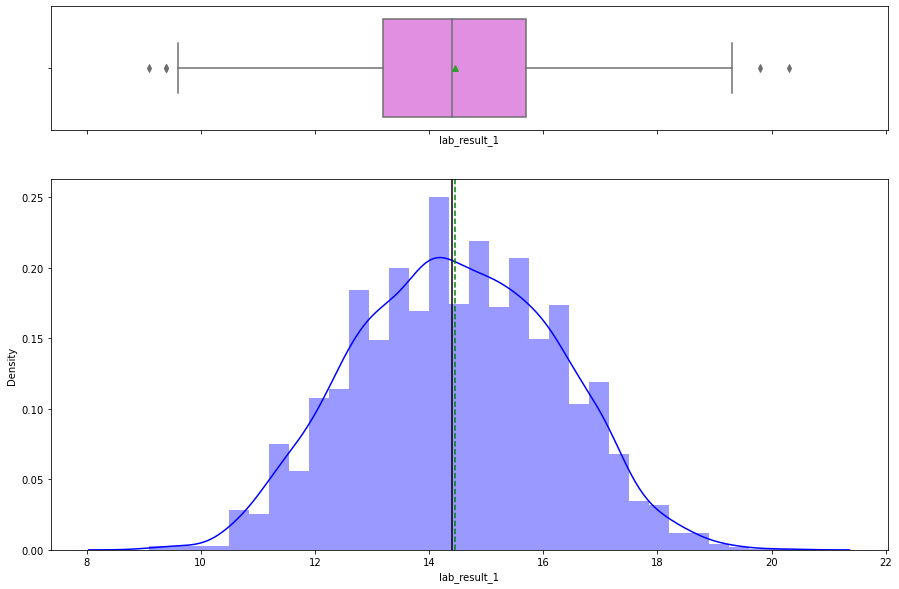

In [45]:
histogram_boxplot(data['lab_result_1'])

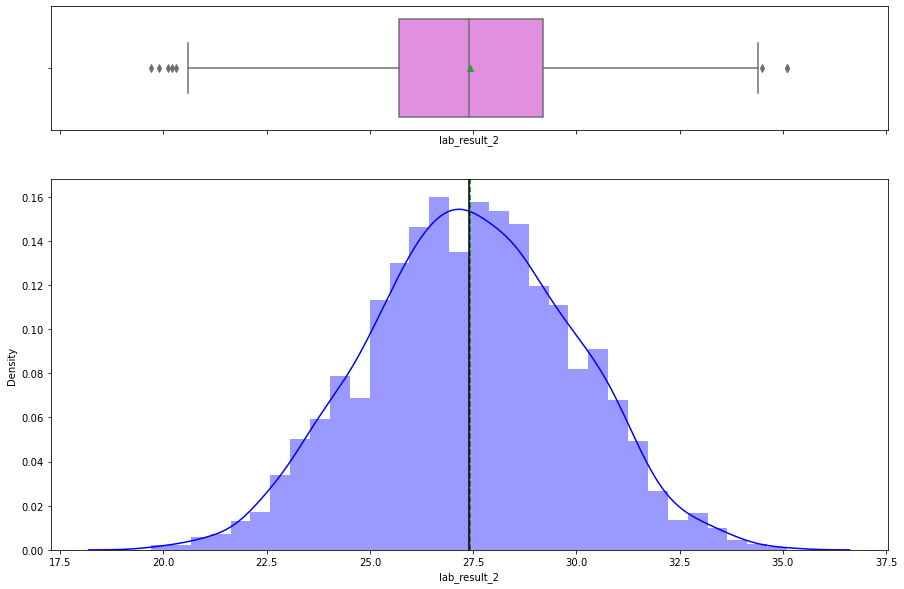

In [46]:
histogram_boxplot(data['lab_result_2'])

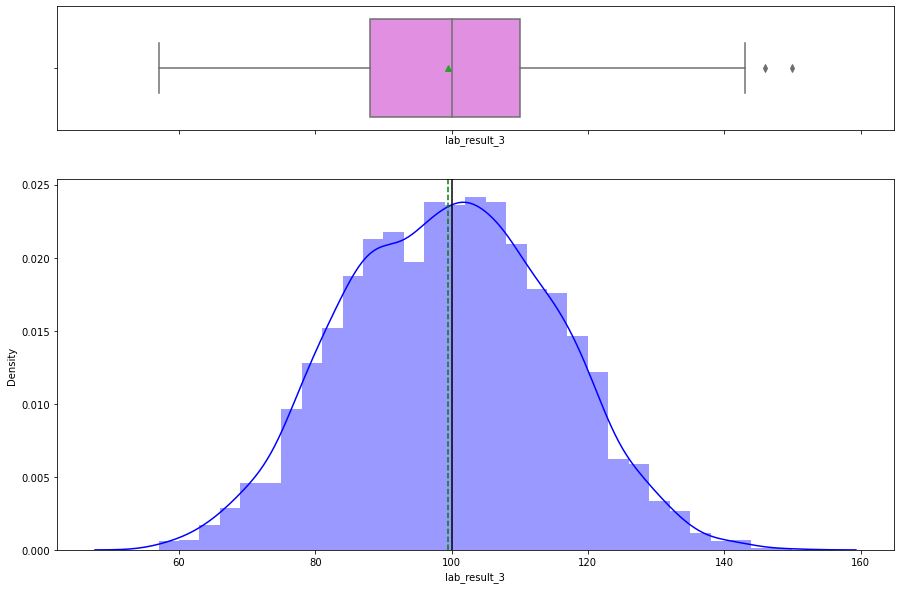

In [47]:
histogram_boxplot(data['lab_result_3'])

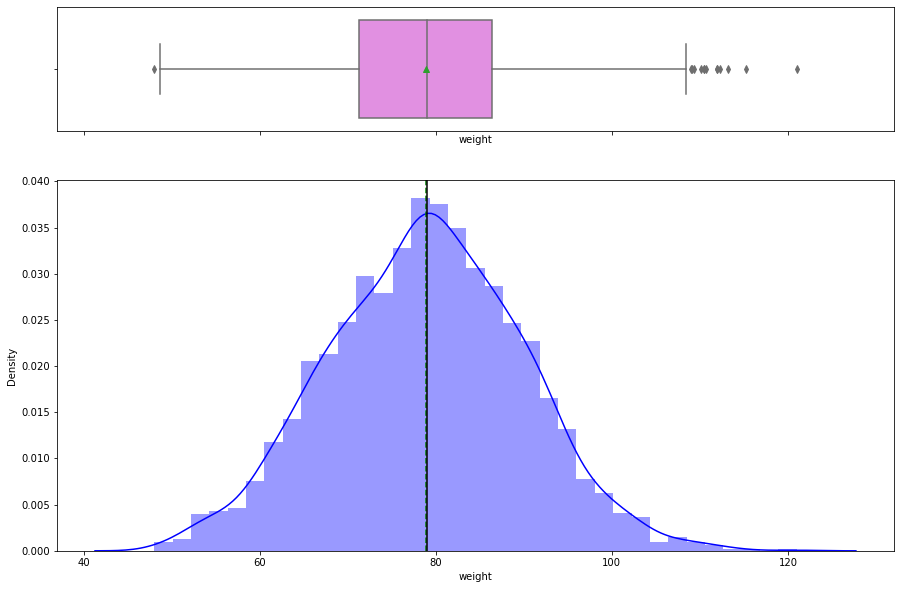

In [48]:
histogram_boxplot(data['weight'])

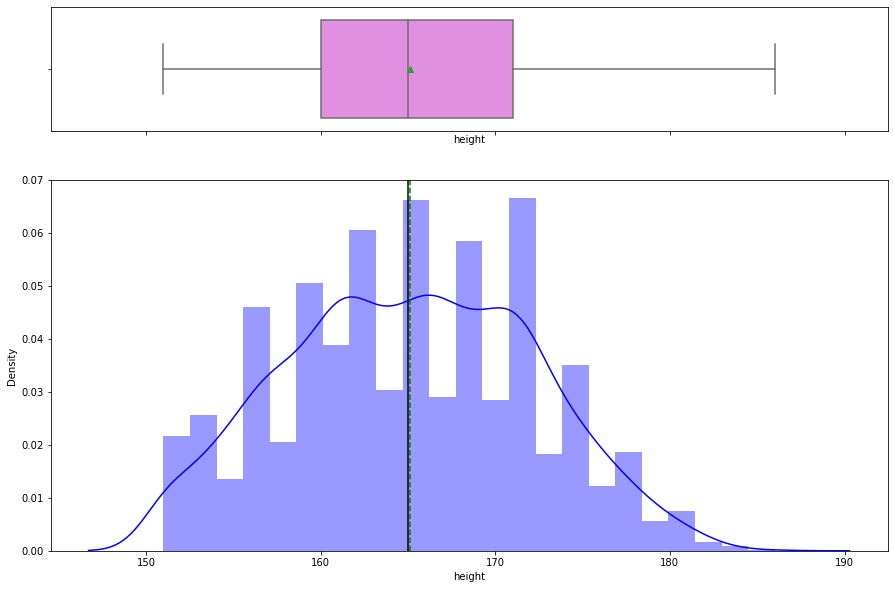

In [49]:
histogram_boxplot(data['height'])

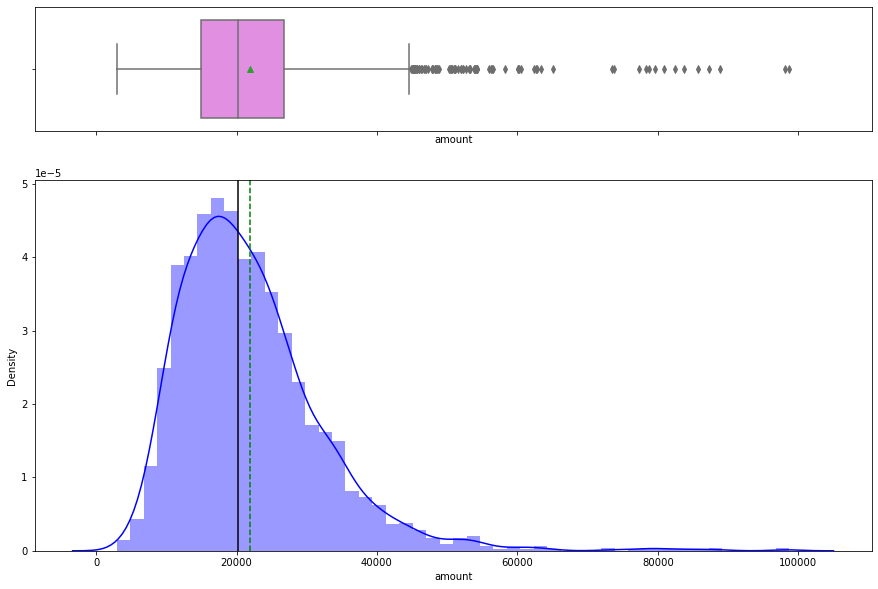

In [50]:
histogram_boxplot(data['amount'])

- `Amount` is right-skewed
- We will perform log-transformation on it

In [51]:
data["log_amount"] = np.log(data["amount"])

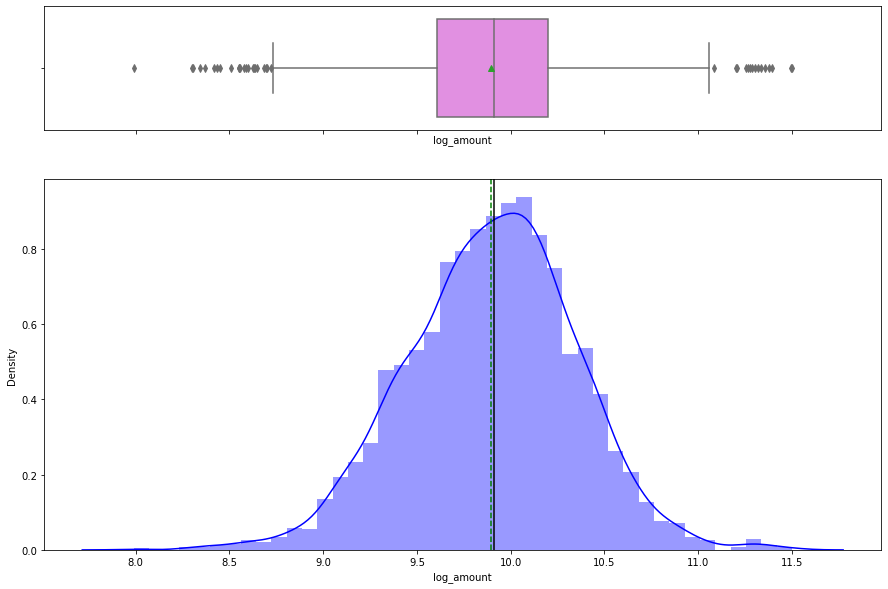

In [52]:
histogram_boxplot(data['log_amount'])

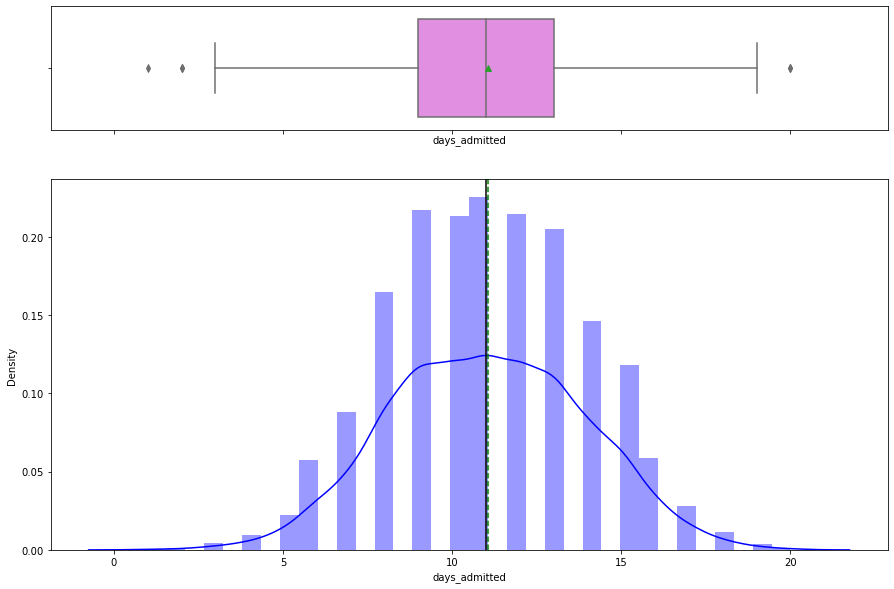

In [53]:
histogram_boxplot(data['days_admitted'])

In [54]:
data['age'] = data['age']/365

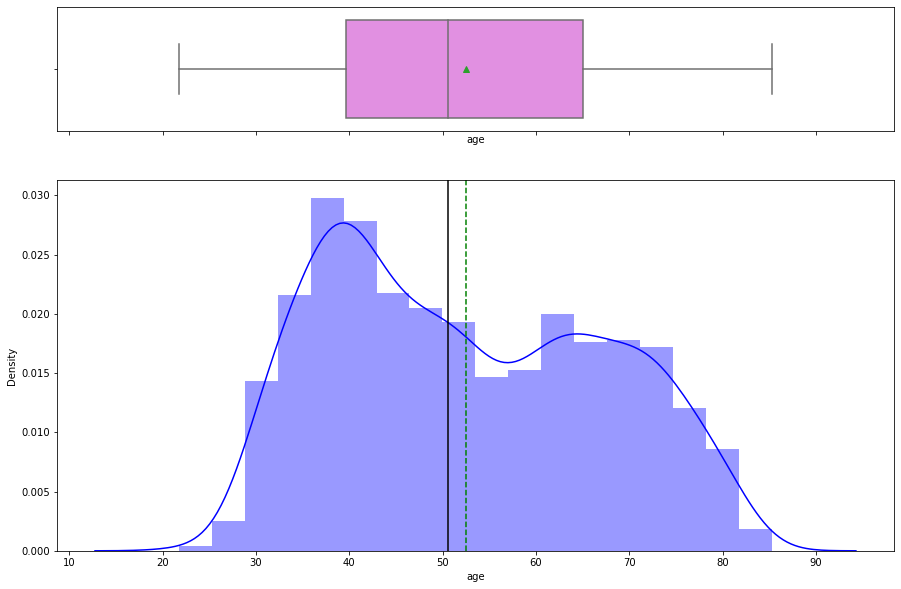

In [55]:
histogram_boxplot(data['age'])

In [56]:
def perc_on_bar(z, order=True):
    total = len(data[z])
    plt.figure(figsize=(15,5))
    if(order==True):
        ax = sns.countplot(data[z], palette = 'Paired', order = data[z].value_counts().index)
    else:
        ax = sns.countplot(data[z], palette = 'Paired')
    
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() /2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x,y), size=12)
    plt.show()        

In [57]:
data.head()

gender     race resident_status  medical_history_1  medical_history_2  \
0  Female   Indian     Singaporean                  0                0.0   
1    Male  Chinese     Singaporean                  0                0.0   
2    Male    Malay     Singaporean                  0                1.0   
3    Male  Chinese     Singaporean                  0                0.0   
4    Male    Malay     Singaporean                  0                0.0   

   medical_history_3  medical_history_4  medical_history_5  medical_history_6  \
0                  0                  0                0.0                  0   
1                  0                  0                0.0                  1   
2                  0                  0                0.0                  0   
3                  0                  0                0.0                  0   
4                  0                  0                1.0                  0   

   medical_history_7  preop_medication_1  preop_medication_2  \
0                  1                   1                   0   
1                  0                   0                   1   
2                  0                   0                   1   
3                  0                   1                   1   
4                  0                   1                   1   

   preop_medication_3  preop_medication_4  preop_medication_5  \
0                   1                   0                   1   
1                   1                   1                   1   
2                   0                   0                   1   
3                   1                   0                   1   
4                   1                   1                   1   

   preop_medication_6  symptom_1  symptom_2  symptom_3  symptom_4  symptom_5  \
0                   1          1          1          0          0          1   
1                   0          0          0          1          1          1   
2                   1          1          1          1          1          1   
3                   1          1          1          1          1          1   
4                   1          1          1          0          1          0   

   lab_result_1  lab_result_2  lab_result_3  weight  height        amount  \
0          14.2          27.0          81.0    68.1   161.0  19564.166266   
1          14.4          26.6          92.0    69.7   175.0  14435.913476   
2          14.9          26.7          97.0    96.9   180.0  45452.313094   
3          14.1          27.3          98.0    91.6   166.0  22511.346126   
4          14.4          27.3         107.0    90.1   173.0  17995.220652   

   days_admitted        age  log_amount  
0             14  43.383562    9.881455  
1             10  28.704110    9.577474  
2             13  68.416438   10.724419  
3             11  40.498630   10.021775  
4             12  36.501370    9.797861

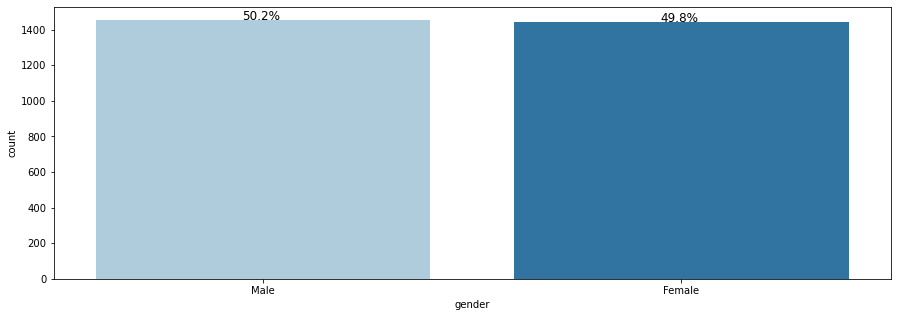

In [58]:
perc_on_bar('gender')

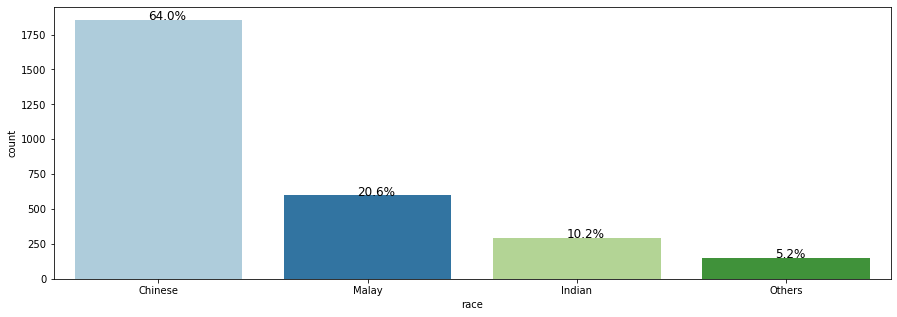

In [59]:
perc_on_bar('race')

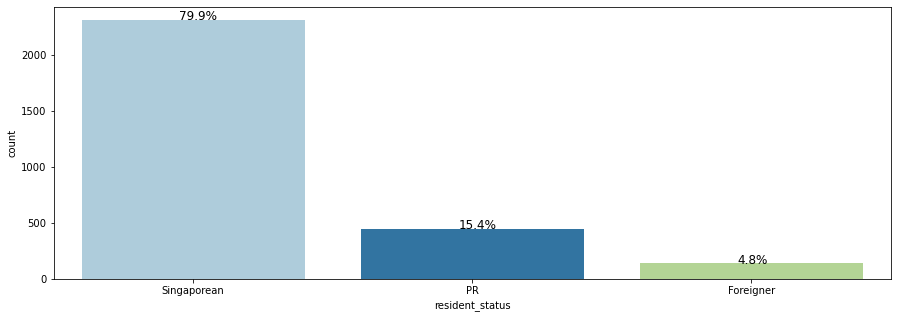

In [60]:
perc_on_bar('resident_status')

## Bivariate Analysis

<AxesSubplot:>

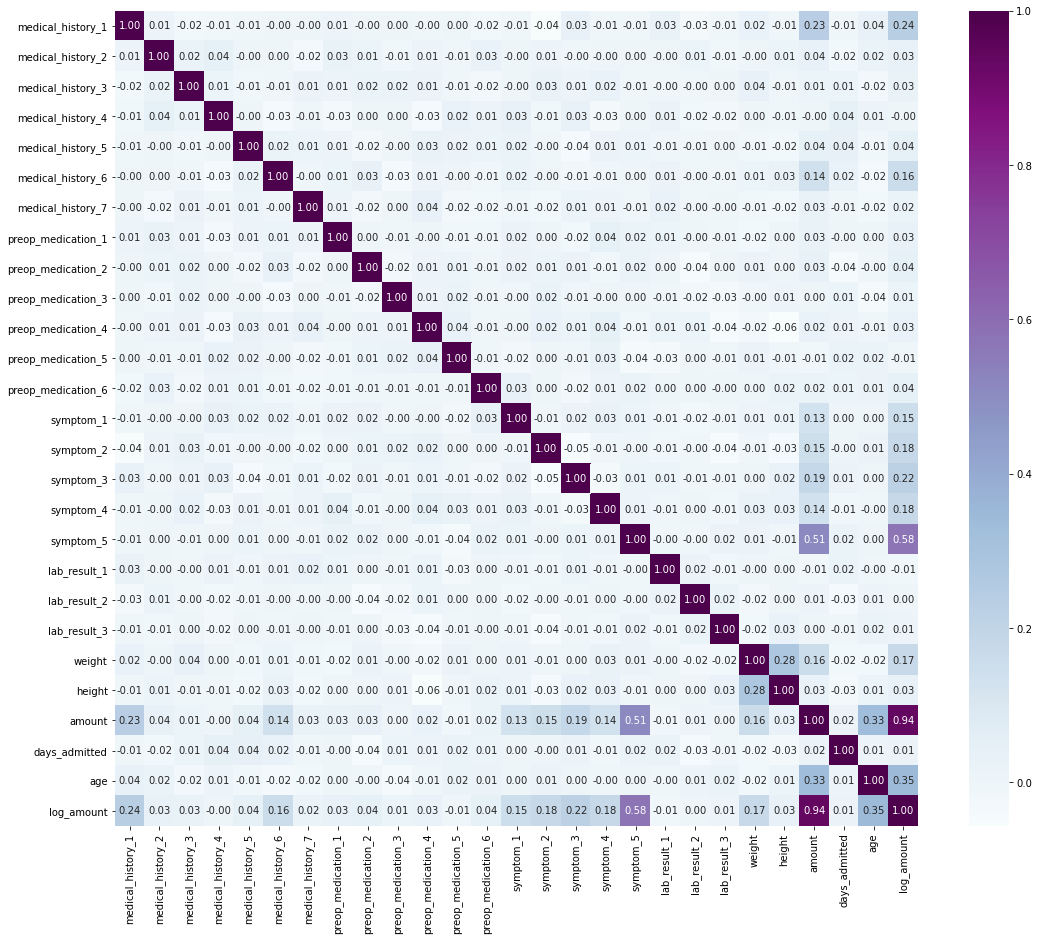

In [61]:
fig= plt.figure(figsize=(18, 15))
sns.heatmap(data.corr(), annot=True, fmt='0.2f', cmap='BuPu')

- **Features with higher correlation** to `log_amount`: 
    * `medical_history_1` 
    * `medical_history_6`
    * `symptom_1`
    * `symptom_2`
    * `symptom_3`
    * `symptom_4`
    * `symptom_5`
    * `weight`
    * `amount` (expected)
    * `age`

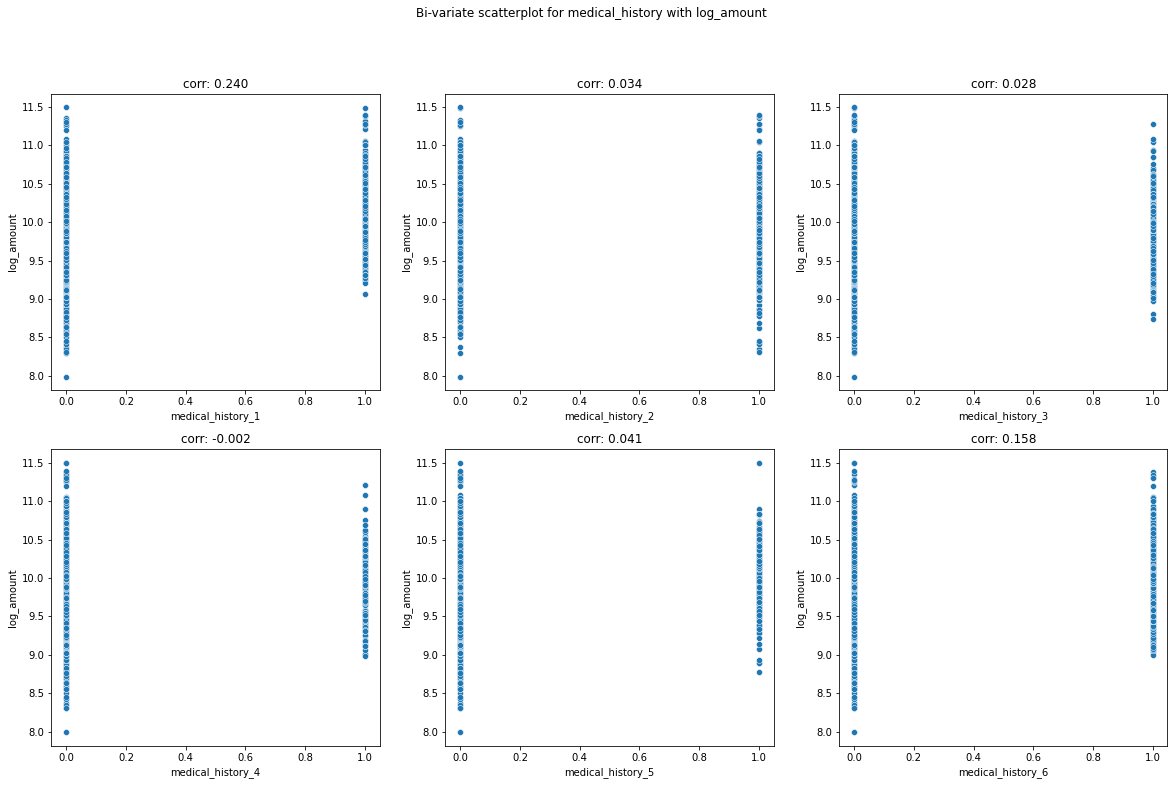

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
  
fig.suptitle('Bi-variate scatterplot for medical_history with log_amount')

c1 = data['medical_history_1'].corr(data['log_amount'])
c2 = data['medical_history_2'].corr(data['log_amount'])
c3 = data['medical_history_3'].corr(data['log_amount'])
c4 = data['medical_history_4'].corr(data['log_amount'])
c5 = data['medical_history_5'].corr(data['log_amount'])
c6 = data['medical_history_6'].corr(data['log_amount'])

sns.scatterplot(x='medical_history_1', y='log_amount', data=data, ax=axes[0,0]).set(title='corr: %.3f' %c1);
sns.scatterplot(x='medical_history_2', y='log_amount', data=data, ax=axes[0,1]).set(title='corr: %.3f' %c2);
sns.scatterplot(x='medical_history_3', y='log_amount', data=data, ax=axes[0,2]).set(title='corr: %.3f' %c3);
sns.scatterplot(x='medical_history_4', y='log_amount', data=data, ax=axes[1,0]).set(title='corr: %.3f' %c4);
sns.scatterplot(x='medical_history_5', y='log_amount', data=data, ax=axes[1,1]).set(title='corr: %.3f' %c5);
sns.scatterplot(x='medical_history_6', y='log_amount', data=data, ax=axes[1,2]).set(title='corr: %.3f' %c6);

- Order of correlation (descending): `medical_history_1`, `medical_history_6`, `medical_history_5`, `medical_history_2`, `medical_history_3`, `medical_history_4`

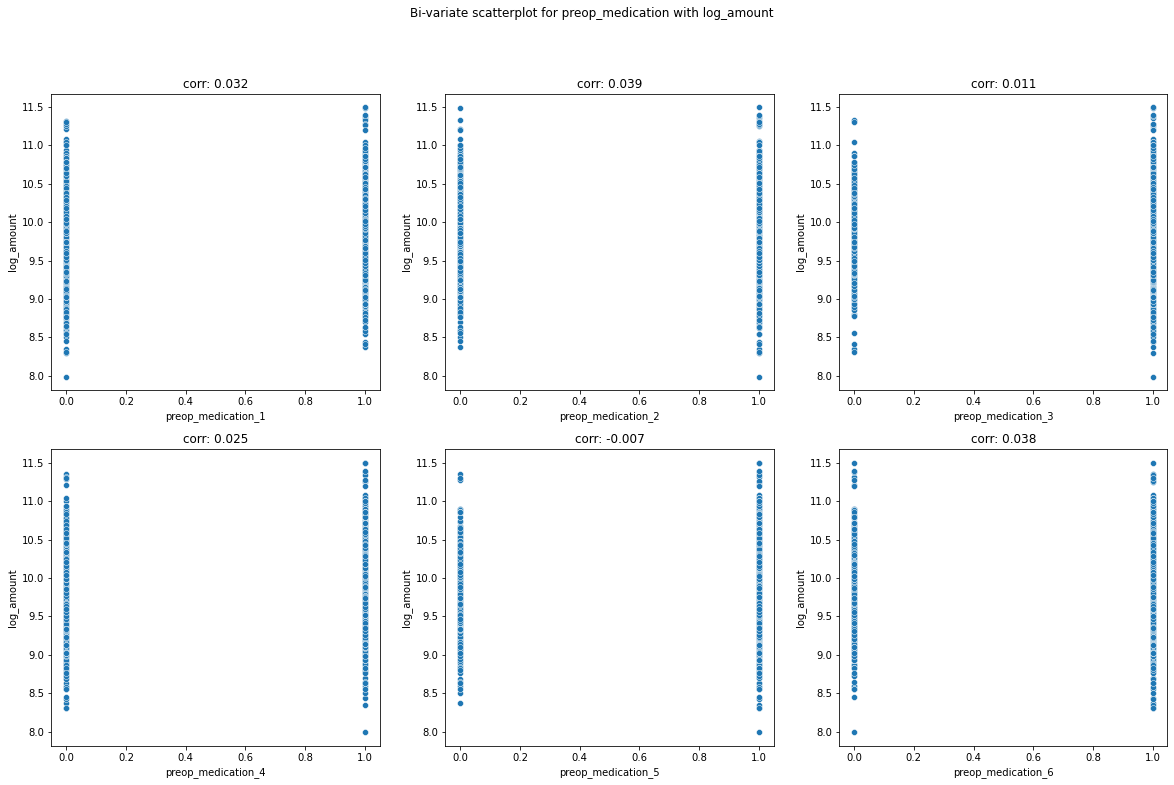

In [63]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Bi-variate scatterplot for preop_medication with log_amount')

c1 = data['preop_medication_1'].corr(data['log_amount'])
c2 = data['preop_medication_2'].corr(data['log_amount'])
c3 = data['preop_medication_3'].corr(data['log_amount'])
c4 = data['preop_medication_4'].corr(data['log_amount'])
c5 = data['preop_medication_5'].corr(data['log_amount'])
c6 = data['preop_medication_6'].corr(data['log_amount'])

sns.scatterplot(x='preop_medication_1', y='log_amount', data=data, ax=axes[0,0]).set(title='corr: %.3f' %c1);
sns.scatterplot(x='preop_medication_2', y='log_amount', data=data, ax=axes[0,1]).set(title='corr: %.3f' %c2);
sns.scatterplot(x='preop_medication_3', y='log_amount', data=data, ax=axes[0,2]).set(title='corr: %.3f' %c3);
sns.scatterplot(x='preop_medication_4', y='log_amount', data=data, ax=axes[1,0]).set(title='corr: %.3f' %c4);
sns.scatterplot(x='preop_medication_5', y='log_amount', data=data, ax=axes[1,1]).set(title='corr: %.3f' %c5);
sns.scatterplot(x='preop_medication_6', y='log_amount', data=data, ax=axes[1,2]).set(title='corr: %.3f' %c6);

- `preop_medication` has **low correlation** with `log_amount` across all 6 features
- Order of correlation (descending): `preop_medication_2`, `preop_medication_6`, `preop_medication_1`, `preop_medication_4`, `preop_medication_3`, `preop_medication_5`

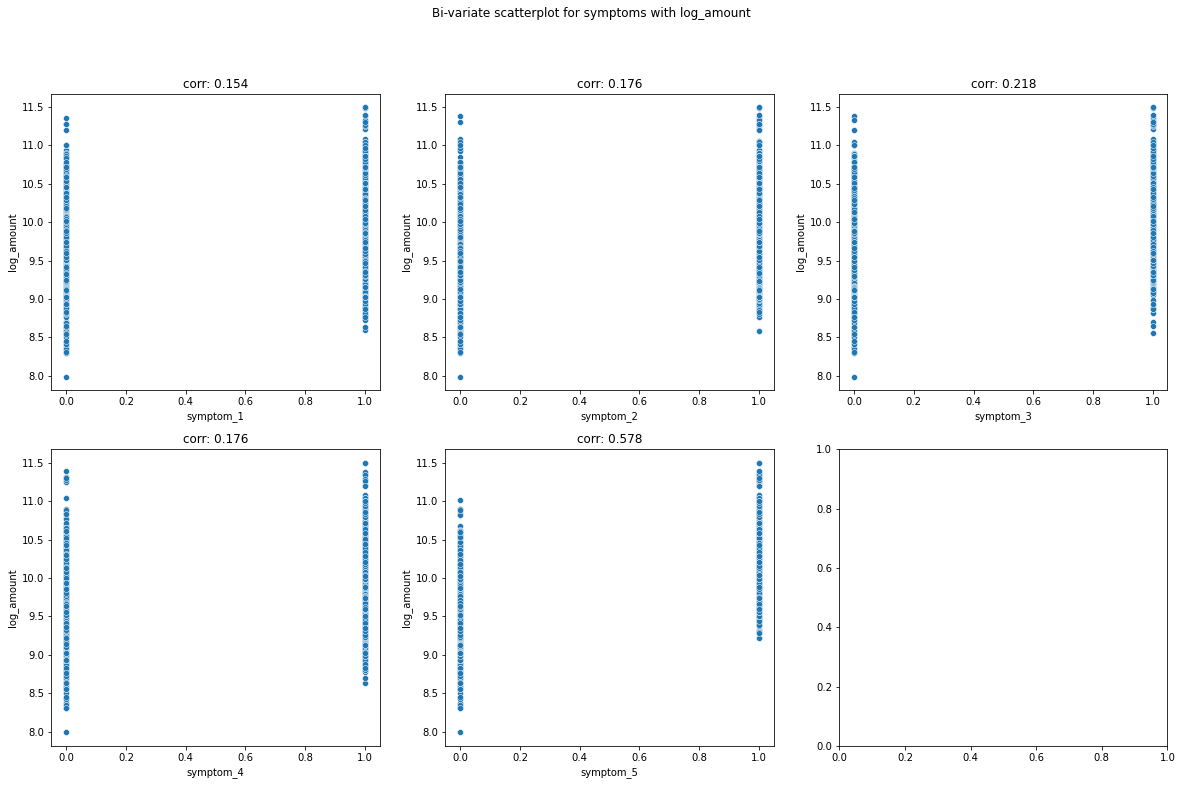

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Bi-variate scatterplot for symptoms with log_amount')

c1 = data['symptom_1'].corr(data['log_amount'])
c2 = data['symptom_2'].corr(data['log_amount'])
c3 = data['symptom_3'].corr(data['log_amount'])
c4 = data['symptom_4'].corr(data['log_amount'])
c5 = data['symptom_5'].corr(data['log_amount'])
  
sns.scatterplot(x='symptom_1', y='log_amount', data=data, ax=axes[0,0]).set(title='corr: %.3f' %c1);
sns.scatterplot(x='symptom_2', y='log_amount', data=data, ax=axes[0,1]).set(title='corr: %.3f' %c2);
sns.scatterplot(x='symptom_3', y='log_amount', data=data, ax=axes[0,2]).set(title='corr: %.3f' %c3);
sns.scatterplot(x='symptom_4', y='log_amount', data=data, ax=axes[1,0]).set(title='corr: %.3f' %c4);
sns.scatterplot(x='symptom_5', y='log_amount', data=data, ax=axes[1,1]).set(title='corr: %.3f' %c5);

- `symptoms` have generally **moderate correlation** with `log_amount`
- Order of correlation (descending): `symptom_5`, `symptom_3`, `symptom_2`, `symptom_4`, `symptom_1`

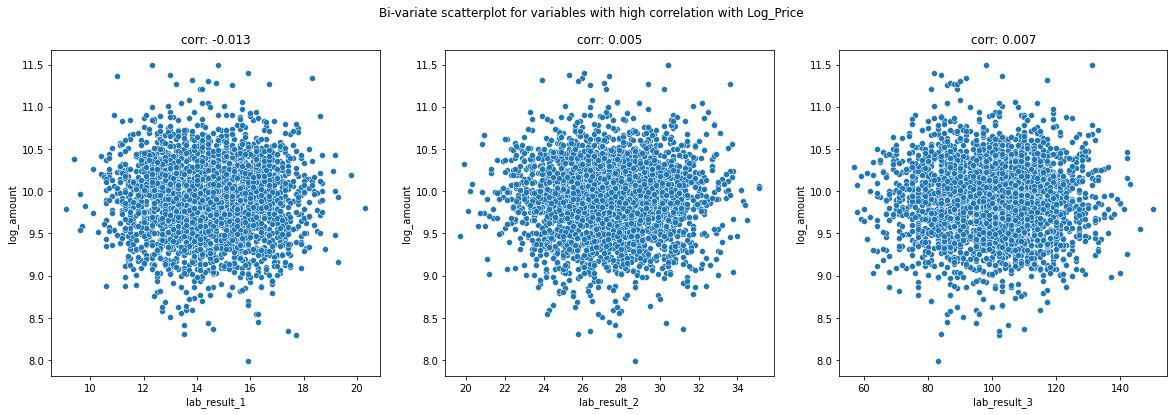

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6)) 
fig.suptitle('Bi-variate scatterplot for variables with high correlation with Log_Price')

c1 = data['lab_result_1'].corr(data['log_amount'])
c2 = data['lab_result_2'].corr(data['log_amount'])
c3 = data['lab_result_3'].corr(data['log_amount'])

sns.scatterplot(x='lab_result_1', y='log_amount', data=data, ax=axes[0]).set(title='corr: %.3f' %c1);
sns.scatterplot(x='lab_result_2', y='log_amount', data=data, ax=axes[1]).set(title='corr: %.3f' %c2);
sns.scatterplot(x='lab_result_3', y='log_amount', data=data, ax=axes[2]).set(title='corr: %.3f' %c3);

- `lab_result1`, `lab_result2`, `lab_result3` have **low correlation** (all magnitude <0.02) with `log_amount`

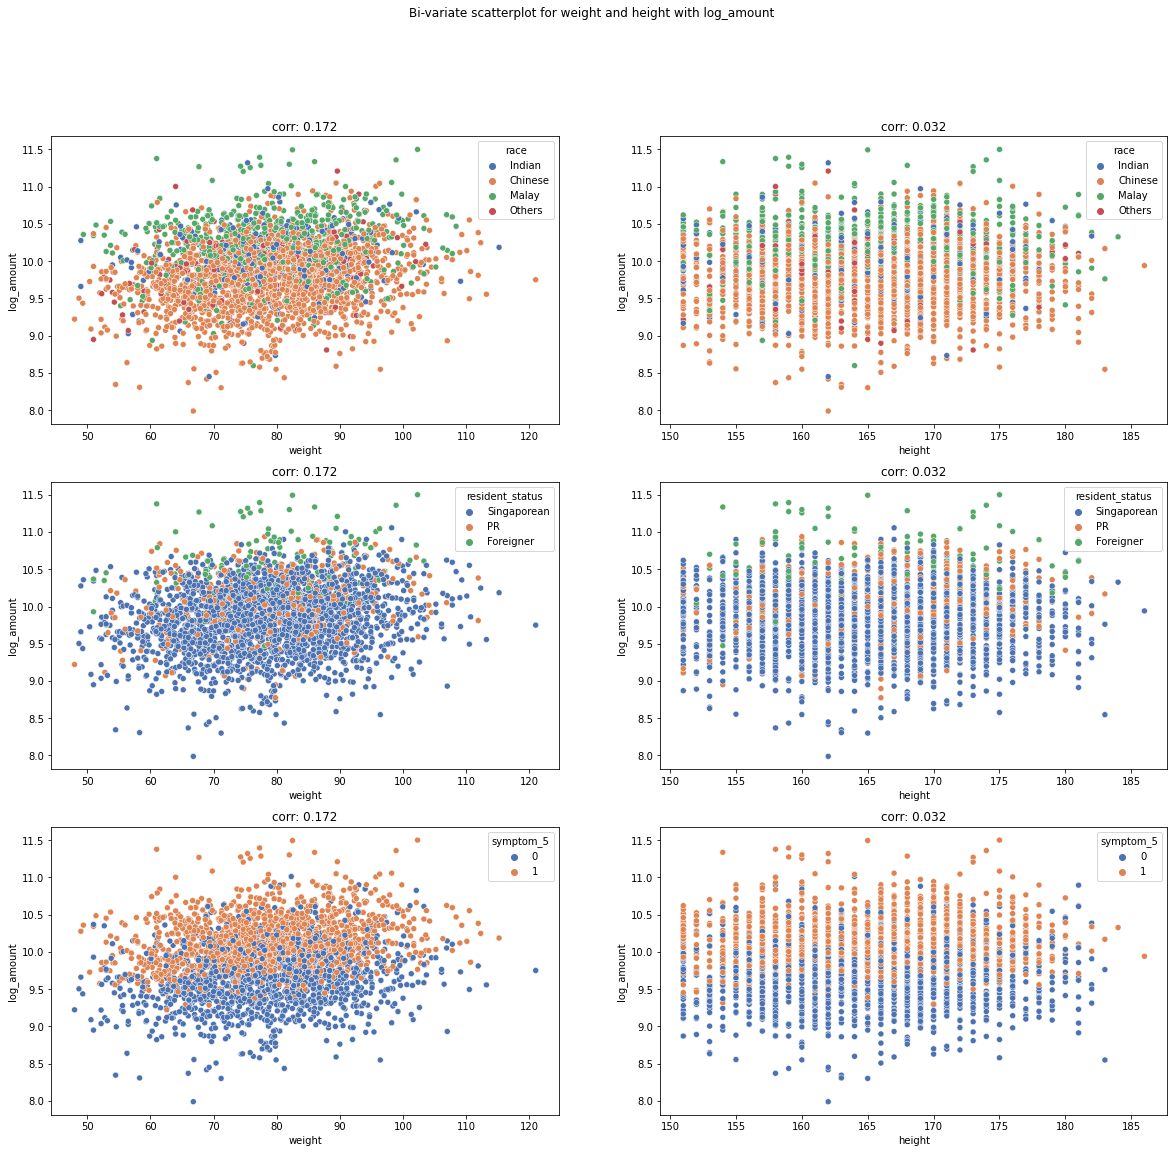

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(20, 18)) 
fig.suptitle('Bi-variate scatterplot for weight and height with log_amount')

c1 = data['weight'].corr(data['log_amount'])
c2 = data['height'].corr(data['log_amount'])

sns.scatterplot(x='weight', y='log_amount', data=data, ax=axes[0,0], hue='race', palette='deep').set(title='corr: %.3f' %c1);
sns.scatterplot(x='height', y='log_amount', data=data, ax=axes[0,1], hue='race', palette='deep').set(title='corr: %.3f' %c2);
sns.scatterplot(x='weight', y='log_amount', data=data, ax=axes[1,0], hue='resident_status', palette='deep').set(title='corr: %.3f' %c1);
sns.scatterplot(x='height', y='log_amount', data=data, ax=axes[1,1], hue='resident_status', palette='deep').set(title='corr: %.3f' %c2);
sns.scatterplot(x='weight', y='log_amount', data=data, ax=axes[2,0], hue='symptom_5', palette='deep').set(title='corr: %.3f' %c1);
sns.scatterplot(x='height', y='log_amount', data=data, ax=axes[2,1], hue='symptom_5', palette='deep').set(title='corr: %.3f' %c2);

- `weight` has **low-moderate correlation** (0.172) with `log_amount`
- `height` has **low correlation** (0.032) with `log_amount`

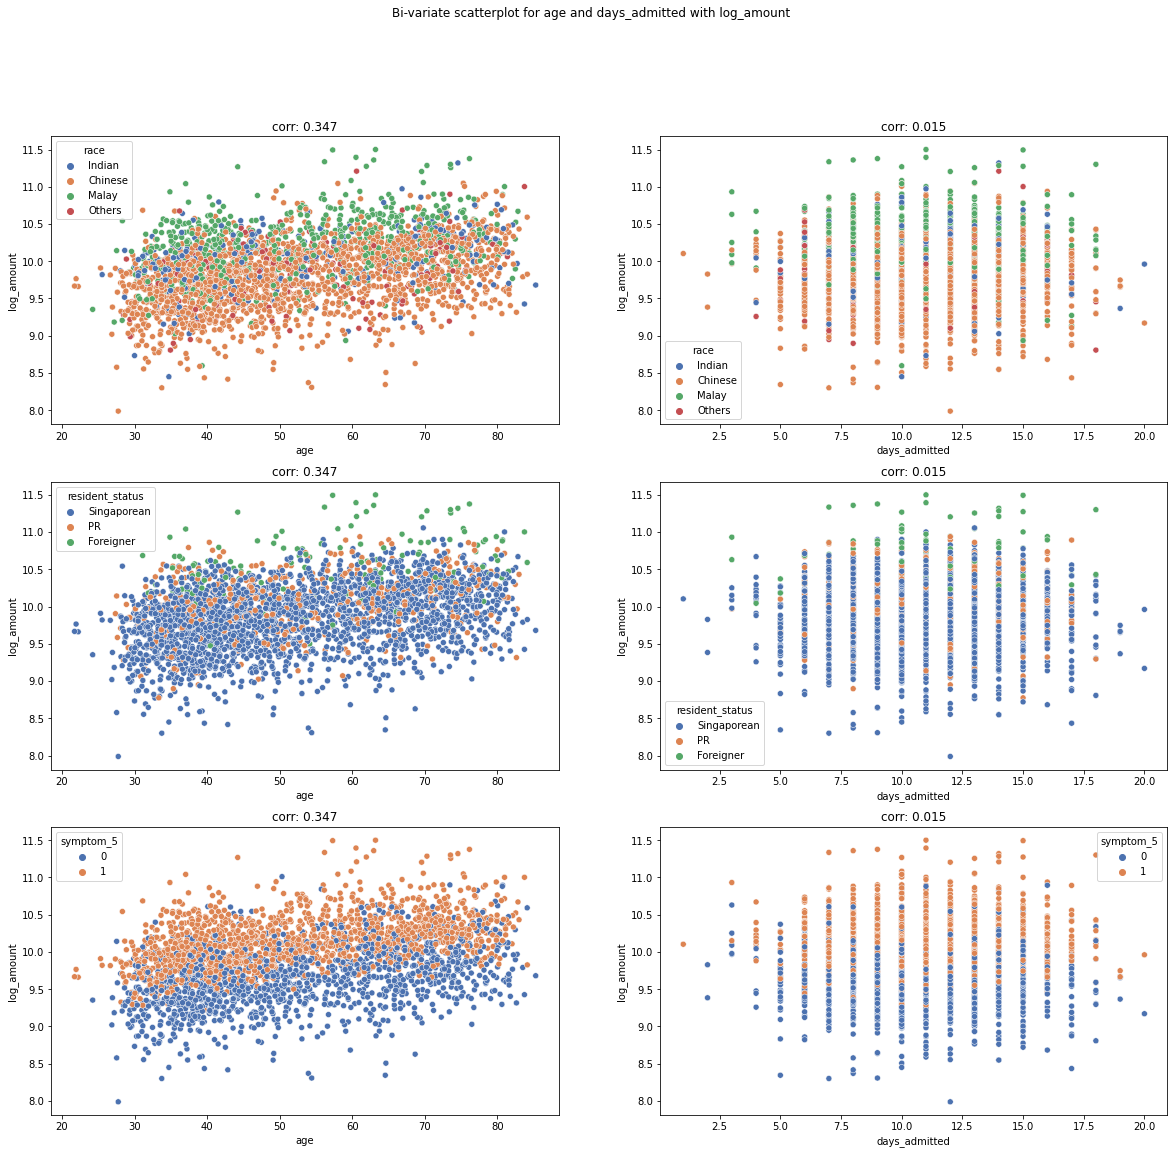

In [67]:
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('Bi-variate scatterplot for age and days_admitted with log_amount')

c1 = data['age'].corr(data['log_amount'])
c2 = data['days_admitted'].corr(data['log_amount'])

sns.scatterplot(x='age', y='log_amount', data=data, ax=axes[0,0], hue='race', palette='deep').set(title='corr: %.3f' %c1);
sns.scatterplot(x='days_admitted', y='log_amount', data=data, ax=axes[0,1], hue='race', palette='deep').set(title='corr: %.3f' %c2);
sns.scatterplot(x='age', y='log_amount', data=data, ax=axes[1,0], hue='resident_status', palette='deep').set(title='corr: %.3f' %c1);
sns.scatterplot(x='days_admitted', y='log_amount', data=data, ax=axes[1,1], hue='resident_status', palette='deep').set(title='corr: %.3f' %c2);
sns.scatterplot(x='age', y='log_amount', data=data, ax=axes[2,0], hue='symptom_5', palette='deep').set(title='corr: %.3f' %c1);
sns.scatterplot(x='days_admitted', y='log_amount', data=data, ax=axes[2,1], hue='symptom_5', palette='deep').set(title='corr: %.3f' %c2);

- `Age`: **Moderate correlation** (0.347)
- `Days_admitted`: **Low correlation** (0.015)
- Across `age` and `days_admitted`: Malays, Foreigners and those with Symptom_5 have higher log_amount values

## Boxplots

In [68]:
def boxplot(z):
    plt.figure(figsize=(12,5))
    sns.boxplot(x=z, y=data['log_amount'])
    plt.show()
    plt.figure(figsize=(12,5))
    plt.title('Without Outliers')
    sns.boxplot(x=z, y=data['log_amount'], showfliers=False)
    plt.show()

In [69]:
data.head()

gender     race resident_status  medical_history_1  medical_history_2  \
0  Female   Indian     Singaporean                  0                0.0   
1    Male  Chinese     Singaporean                  0                0.0   
2    Male    Malay     Singaporean                  0                1.0   
3    Male  Chinese     Singaporean                  0                0.0   
4    Male    Malay     Singaporean                  0                0.0   

   medical_history_3  medical_history_4  medical_history_5  medical_history_6  \
0                  0                  0                0.0                  0   
1                  0                  0                0.0                  1   
2                  0                  0                0.0                  0   
3                  0                  0                0.0                  0   
4                  0                  0                1.0                  0   

   medical_history_7  preop_medication_1  preop_medication_2  \
0                  1                   1                   0   
1                  0                   0                   1   
2                  0                   0                   1   
3                  0                   1                   1   
4                  0                   1                   1   

   preop_medication_3  preop_medication_4  preop_medication_5  \
0                   1                   0                   1   
1                   1                   1                   1   
2                   0                   0                   1   
3                   1                   0                   1   
4                   1                   1                   1   

   preop_medication_6  symptom_1  symptom_2  symptom_3  symptom_4  symptom_5  \
0                   1          1          1          0          0          1   
1                   0          0          0          1          1          1   
2                   1          1          1          1          1          1   
3                   1          1          1          1          1          1   
4                   1          1          1          0          1          0   

   lab_result_1  lab_result_2  lab_result_3  weight  height        amount  \
0          14.2          27.0          81.0    68.1   161.0  19564.166266   
1          14.4          26.6          92.0    69.7   175.0  14435.913476   
2          14.9          26.7          97.0    96.9   180.0  45452.313094   
3          14.1          27.3          98.0    91.6   166.0  22511.346126   
4          14.4          27.3         107.0    90.1   173.0  17995.220652   

   days_admitted        age  log_amount  
0             14  43.383562    9.881455  
1             10  28.704110    9.577474  
2             13  68.416438   10.724419  
3             11  40.498630   10.021775  
4             12  36.501370    9.797861

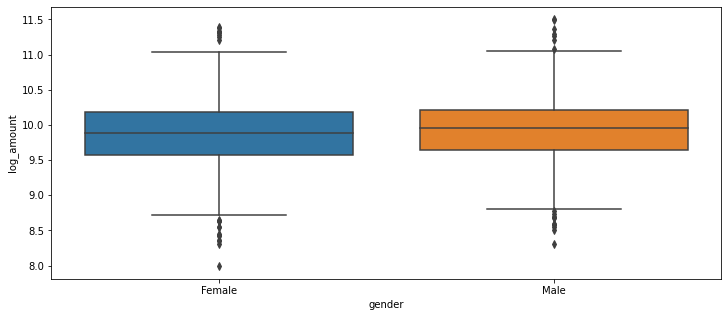

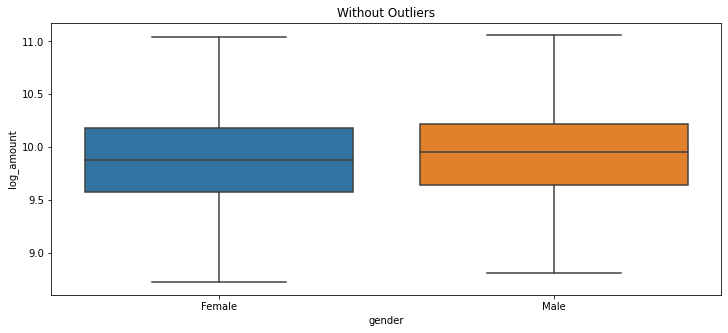

In [70]:
boxplot(data['gender'])

- No observable difference between Male and Female

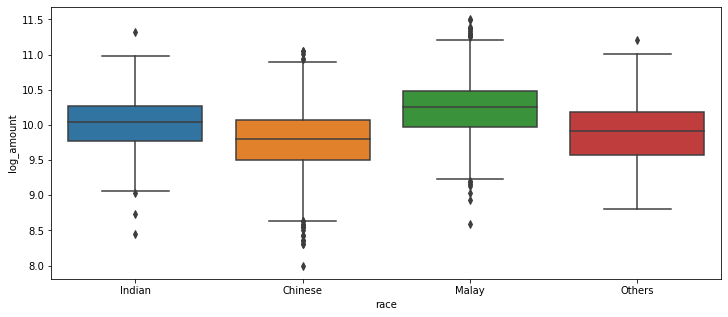

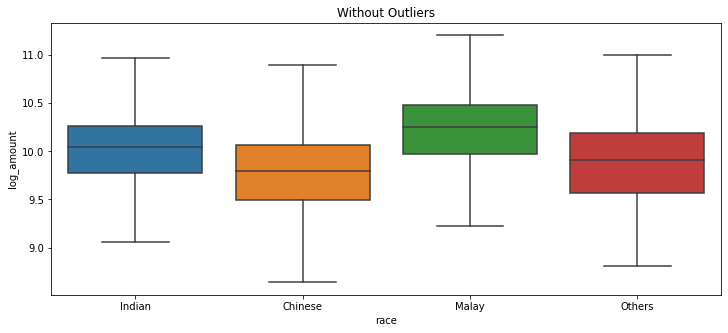

In [71]:
boxplot(data['race'])

- Order of middle inter-quartile range (descending): Malay, Indian, Others, Chinese

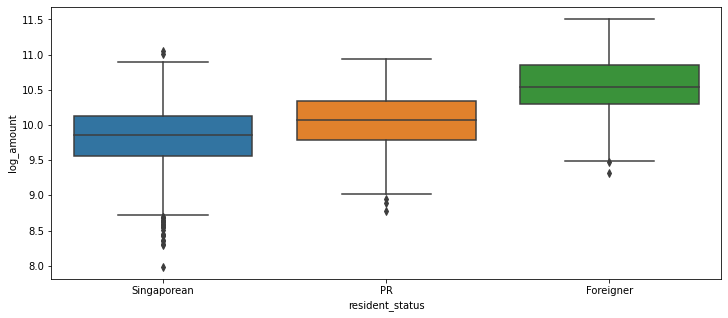

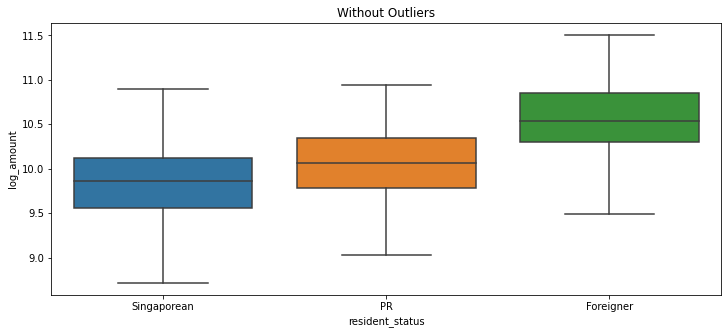

In [72]:
boxplot(data['resident_status'])

- Order of middle inter-quartile range (descending): Foreigner, PR, Singaporean

## Section 3: Dimensionality Reduction

In [73]:
[col for col in data.columns]

['gender',
 'race',
 'resident_status',
 'medical_history_1',
 'medical_history_2',
 'medical_history_3',
 'medical_history_4',
 'medical_history_5',
 'medical_history_6',
 'medical_history_7',
 'preop_medication_1',
 'preop_medication_2',
 'preop_medication_3',
 'preop_medication_4',
 'preop_medication_5',
 'preop_medication_6',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5',
 'lab_result_1',
 'lab_result_2',
 'lab_result_3',
 'weight',
 'height',
 'amount',
 'days_admitted',
 'age',
 'log_amount']

In [74]:
from sklearn.preprocessing import StandardScaler

data_pca = data
data_pca = pd.get_dummies(data_pca, drop_first=True)
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data_pca), columns=data_pca.columns)

In [75]:
data_scaled.head()

medical_history_1  medical_history_2  medical_history_3  medical_history_4  \
0          -0.454969          -0.681994          -0.398999          -0.240134   
1          -0.454969          -0.681994          -0.398999          -0.240134   
2          -0.454969           1.466288          -0.398999          -0.240134   
3          -0.454969          -0.681994          -0.398999          -0.240134   
4          -0.454969          -0.681994          -0.398999          -0.240134   

   medical_history_5  medical_history_6  medical_history_7  \
0          -0.263387          -0.587179           1.713914   
1          -0.263387           1.703057          -0.583460   
2          -0.263387          -0.587179          -0.583460   
3          -0.263387          -0.587179          -0.583460   
4           3.796695          -0.587179          -0.583460   

   preop_medication_1  preop_medication_2  preop_medication_3  \
0             0.99931           -1.193777            0.465978   
1            -1.00069            0.837677            0.465978   
2            -1.00069            0.837677           -2.146023   
3             0.99931            0.837677            0.465978   
4             0.99931            0.837677            0.465978   

   preop_medication_4  preop_medication_5  preop_medication_6  symptom_1  \
0           -1.045911            0.462684            0.578678   0.789639   
1            0.956104            0.462684           -1.728075  -1.266402   
2           -1.045911            0.462684            0.578678   0.789639   
3           -1.045911            0.462684            0.578678   0.789639   
4            0.956104            0.462684            0.578678   0.789639   

   symptom_2  symptom_3  symptom_4  symptom_5  lab_result_1  lab_result_2  \
0   0.714807  -1.106390  -1.626433   0.944924     -0.147810     -0.169867   
1  -1.398979   0.903841   0.614843   0.944924     -0.033277     -0.330939   
2   0.714807   0.903841   0.614843   0.944924      0.253055     -0.290671   
3   0.714807   0.903841   0.614843   0.944924     -0.205076     -0.049064   
4   0.714807  -1.106390   0.614843  -1.058287     -0.033277     -0.049064   

   lab_result_3    weight    height    amount  days_admitted       age  \
0     -1.210700 -0.975395 -0.587864 -0.230897       1.031113 -0.617405   
1     -0.491495 -0.830356  1.403188 -0.728054      -0.365063 -1.615364   
2     -0.164584  1.635318  2.114277  2.278825       0.682069  1.084414   
3     -0.099201  1.154874  0.123226  0.054817      -0.016019 -0.813533   
4      0.489239  1.018900  1.118752 -0.382998       0.333025 -1.085280   

   log_amount  gender_Male  race_Indian  race_Malay  race_Others  \
0   -0.034127    -1.003457     2.970476   -0.509902    -0.233635   
1   -0.710889     0.996555    -0.336646   -0.509902    -0.233635   
2    1.842593     0.996555    -0.336646    1.961161    -0.233635   
3    0.278272     0.996555    -0.336646   -0.509902    -0.233635   
4   -0.220234     0.996555    -0.336646    1.961161    -0.233635   

   resident_status_PR  resident_status_Singaporean  
0           -0.425923                     0.501832  
1           -0.425923                     0.501832  
2           -0.425923                     0.501832  
3           -0.425923                     0.501832  
4           -0.425923                     0.501832

In [76]:
#Importing PCA and TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [77]:
#Defining the number of principal components to generate 
n=data_scaled.shape[1]

#Finding principal components for the data
pca = PCA(n_components=n, random_state=1)
data_pca1 = pd.DataFrame(pca.fit_transform(data_scaled))

#The percentage of variance explained by each principal component
exp_var = pca.explained_variance_ratio_

In [78]:
pca.explained_variance_ratio_.cumsum()

array([0.09057373, 0.14953506, 0.20295452, 0.23990983, 0.2755157 ,
       0.3102021 , 0.34386207, 0.37703018, 0.40974646, 0.44243474,
       0.47451188, 0.50610391, 0.53756031, 0.56850144, 0.59890705,
       0.62877607, 0.65835608, 0.68782128, 0.71687861, 0.74586612,
       0.77444112, 0.80277343, 0.83059969, 0.85787936, 0.88487123,
       0.91134033, 0.93763919, 0.96043439, 0.98294708, 0.99111753,
       0.99831705, 0.99972578, 1.        ])

Text(0, 0.5, 'Cumulative Explained Variance')

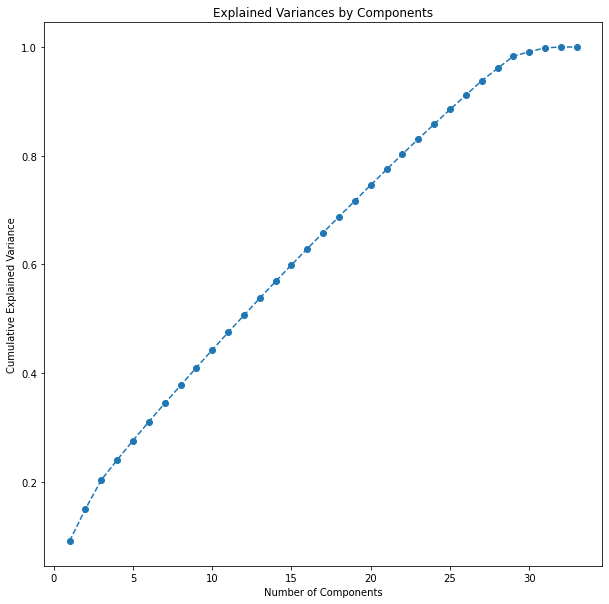

In [79]:
# visulaize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,n+1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [80]:
# find the least number of components that can explain more than 70% variance
sum = 0
for ix, i in enumerate(exp_var):
  sum = sum + i
  if(sum>0.70):
    print("Number of PCs that explain at least 70% variance: ", ix+1)
    break

Number of PCs that explain at least 70% variance:  19


In [81]:
pc_comps = ['PC1','PC2','PC3','PC4', 'PC5','PC6','PC7','PC8', 'PC9','PC10','PC11','PC12', 'PC13','PC14','PC15','PC16', 'PC17', 'PC18', 'PC19']
data_pca = pd.DataFrame(np.round(pca.components_[:19,:],2),index=pc_comps,columns=data_scaled.columns)
data_pca.T

PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8  \
medical_history_1            0.13 -0.05 -0.12  0.03 -0.16  0.25  0.29 -0.06   
medical_history_2            0.02 -0.01 -0.05  0.10  0.01 -0.07 -0.22 -0.16   
medical_history_3            0.02  0.00 -0.01 -0.13  0.21 -0.14  0.07 -0.20   
medical_history_4           -0.01 -0.02 -0.03  0.07  0.30  0.33 -0.29  0.00   
medical_history_5            0.03 -0.05  0.04 -0.10  0.08 -0.14 -0.12  0.43   
medical_history_6            0.09  0.02 -0.02  0.04  0.03 -0.16  0.14  0.28   
medical_history_7            0.01 -0.05  0.08  0.08  0.08 -0.06  0.43  0.10   
preop_medication_1           0.02 -0.02 -0.01  0.10 -0.06 -0.29  0.11  0.17   
preop_medication_2           0.02 -0.01 -0.06  0.10  0.06 -0.10  0.07 -0.15   
preop_medication_3          -0.00  0.01 -0.03 -0.11  0.29 -0.06 -0.02 -0.12   
preop_medication_4           0.02 -0.09  0.04 -0.18  0.13 -0.29  0.22 -0.07   
preop_medication_5          -0.01 -0.01  0.03 -0.13  0.06 -0.07 -0.15 -0.16   
preop_medication_6           0.02  0.01 -0.03  0.00 -0.06 -0.02 -0.38  0.22   
symptom_1                    0.08 -0.01 -0.08 -0.05 -0.03 -0.01 -0.13  0.35   
symptom_2                    0.08 -0.06 -0.05 -0.02  0.11 -0.38 -0.26 -0.31   
symptom_3                    0.12  0.00 -0.06  0.11  0.17  0.38  0.26 -0.09   
symptom_4                    0.09  0.01 -0.04 -0.14 -0.07 -0.37  0.10  0.14   
symptom_5                    0.31 -0.08 -0.20  0.22  0.08 -0.08 -0.05  0.17   
lab_result_1                -0.01 -0.02  0.00  0.09  0.01  0.09  0.26  0.15   
lab_result_2                 0.00 -0.01  0.03  0.04 -0.18 -0.10  0.00 -0.15   
lab_result_3                -0.00  0.03 -0.03  0.19 -0.22  0.12 -0.02  0.08   
weight                       0.13  0.41 -0.06 -0.08  0.11 -0.04  0.05 -0.03   
height                       0.08  0.61  0.01  0.02 -0.02 -0.00 -0.02  0.03   
amount                       0.54 -0.09 -0.14 -0.01 -0.02  0.01  0.01 -0.02   
days_admitted                0.02 -0.06  0.09 -0.06  0.28  0.17 -0.17  0.35   
age                          0.20 -0.05 -0.08  0.16 -0.24  0.10 -0.23 -0.20   
log_amount                   0.55 -0.08 -0.16  0.02  0.00 -0.02  0.00 -0.00   
gender_Male                  0.10  0.63 -0.01 -0.00 -0.01 -0.02 -0.01  0.00   
race_Indian                  0.02 -0.01 -0.09  0.53  0.41 -0.14  0.02 -0.09   
race_Malay                   0.21 -0.08 -0.10 -0.60 -0.08  0.16  0.02 -0.09   
race_Others                 -0.02 -0.02  0.02  0.24 -0.50 -0.10 -0.03 -0.01   
resident_status_PR           0.20 -0.01  0.66  0.05  0.02  0.02 -0.01 -0.03   
resident_status_Singaporean -0.28  0.02 -0.63 -0.05  0.00 -0.02  0.03  0.05   

                              PC9  PC10  PC11  PC12  PC13  PC14  PC15  PC16  \
medical_history_1            0.33 -0.12 -0.12 -0.01  0.22  0.24 -0.15  0.23   
medical_history_2            0.15  0.17  0.42  0.29  0.06  0.29 -0.24  0.20   
medical_history_3           -0.10  0.16  0.27 -0.12 -0.19  0.25  0.51  0.10   
medical_history_4            0.21  0.06  0.23  0.04 -0.13  0.05  0.14 -0.09   
medical_history_5            0.02 -0.14 -0.15  0.16 -0.07  0.08 -0.04  0.37   
medical_history_6           -0.03  0.34 -0.30  0.36  0.17 -0.04  0.03 -0.21   
medical_history_7           -0.02 -0.16  0.16 -0.12 -0.11 -0.11  0.14  0.31   
preop_medication_1           0.08  0.05  0.19 -0.05  0.11  0.54 -0.15 -0.30   
preop_medication_2           0.12  0.57 -0.20  0.03 -0.21 -0.05 -0.04  0.18   
preop_medication_3           0.04 -0.29 -0.04 -0.39  0.15  0.01 -0.23 -0.05   
preop_medication_4           0.23 -0.11  0.07  0.27 -0.11 -0.27  0.00  0.18   
preop_medication_5           0.40 -0.23 -0.33  0.24 -0.29  0.03  0.06 -0.15   
preop_medication_6           0.01 -0.03  0.27  0.04  0.04 -0.29 -0.15  0.36   
symptom_1                    0.24  0.26  0.19 -0.20 -0.20 -0.21 -0.01 -0.25   
symptom_2                   -0.04  0.06 -0.12 -0.13  0.35 -0.16  0.27  0.00   
symptom_3                    0.12  0.03  0.12  0.04 -0.19 -0.23 -0.05 -0.22   


In [82]:
def color_high(val):
    if val <-0.25: # you can decide any value as per your understanding
        return 'background: pink'
    elif val >0.25:
        return 'background: skyblue'   
    
data_pca.T.style.applymap(color_high)

- The first Principal Component is positively related with `symptom_5`, `amount` and `log_amount` and negatively correlated with `resident_status_Singaporean`
- This captures the observation that those with `symptom_5` are related to higher `amounts`
- It also captures that those who are Singaporean are related to lower `amounts`
- **Conclusion from PCA**: `symptom_5` and `resident_status_Singaporean` are important features to predict `amount` and `log_amount`

<AxesSubplot:xlabel='X1', ylabel='X2'>

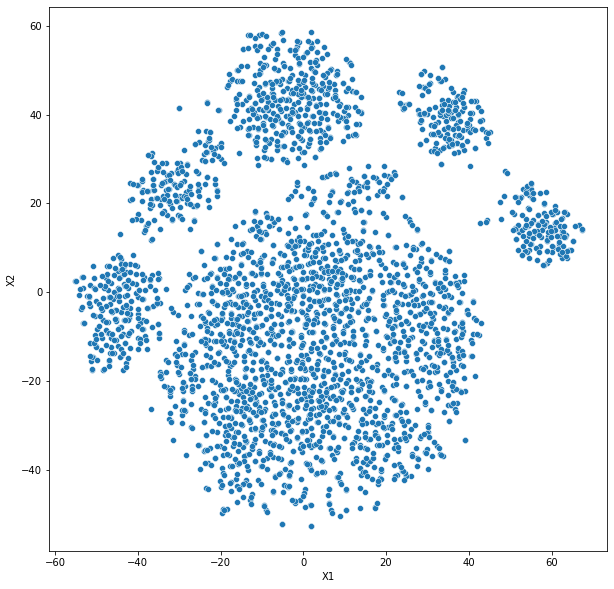

In [83]:
data_tsne = data
data_tsne = pd.get_dummies(data_tsne, drop_first=True)
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data_tsne), columns=data_tsne.columns)

#Fitting TSNE with number of components equal to 2 
tsne = TSNE(n_components = 2, random_state=1, perplexity=35)
data_tsne = tsne.fit_transform(data_scaled)

#Converting the embeddings to a dataframe
data_tsne=pd.DataFrame(data_tsne, columns=['X1', 'X2'])

#Scatter plot for two components
plt.figure(figsize = (10,10))
sns.scatterplot(x = 'X1', y='X2', data = data_tsne)

In [84]:
def grouping(x):
    first_component = x['X1']
    second_component = x['X2']
    if (0 < second_component < 28) and (first_component > 40): 
        return 'group_1'
    elif (second_component > 28) and (first_component > 20): 
        return 'group_2'
    elif (second_component > 29)  and (-20 < first_component < 20):
        return 'group_3'
    elif (second_component > 10)  and (first_component < -20):
        return 'group_4'
    elif (-18 < second_component < 10)  and (first_component < -34):
        return 'group_5'
    else: 
        return 'group_6'

In [85]:
data_tsne['groups'] = data_tsne.apply(grouping, axis=1)

<AxesSubplot:xlabel='X1', ylabel='X2'>

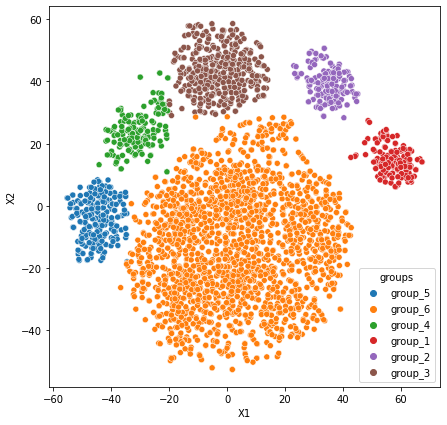

In [86]:
#Scatter plot for two components with hue
plt.figure(figsize = (7,7))
sns.scatterplot(x = 'X1', y='X2', data = data_tsne, hue='groups')

- There are 6 observable groupings in the tSNE plot with 2 components

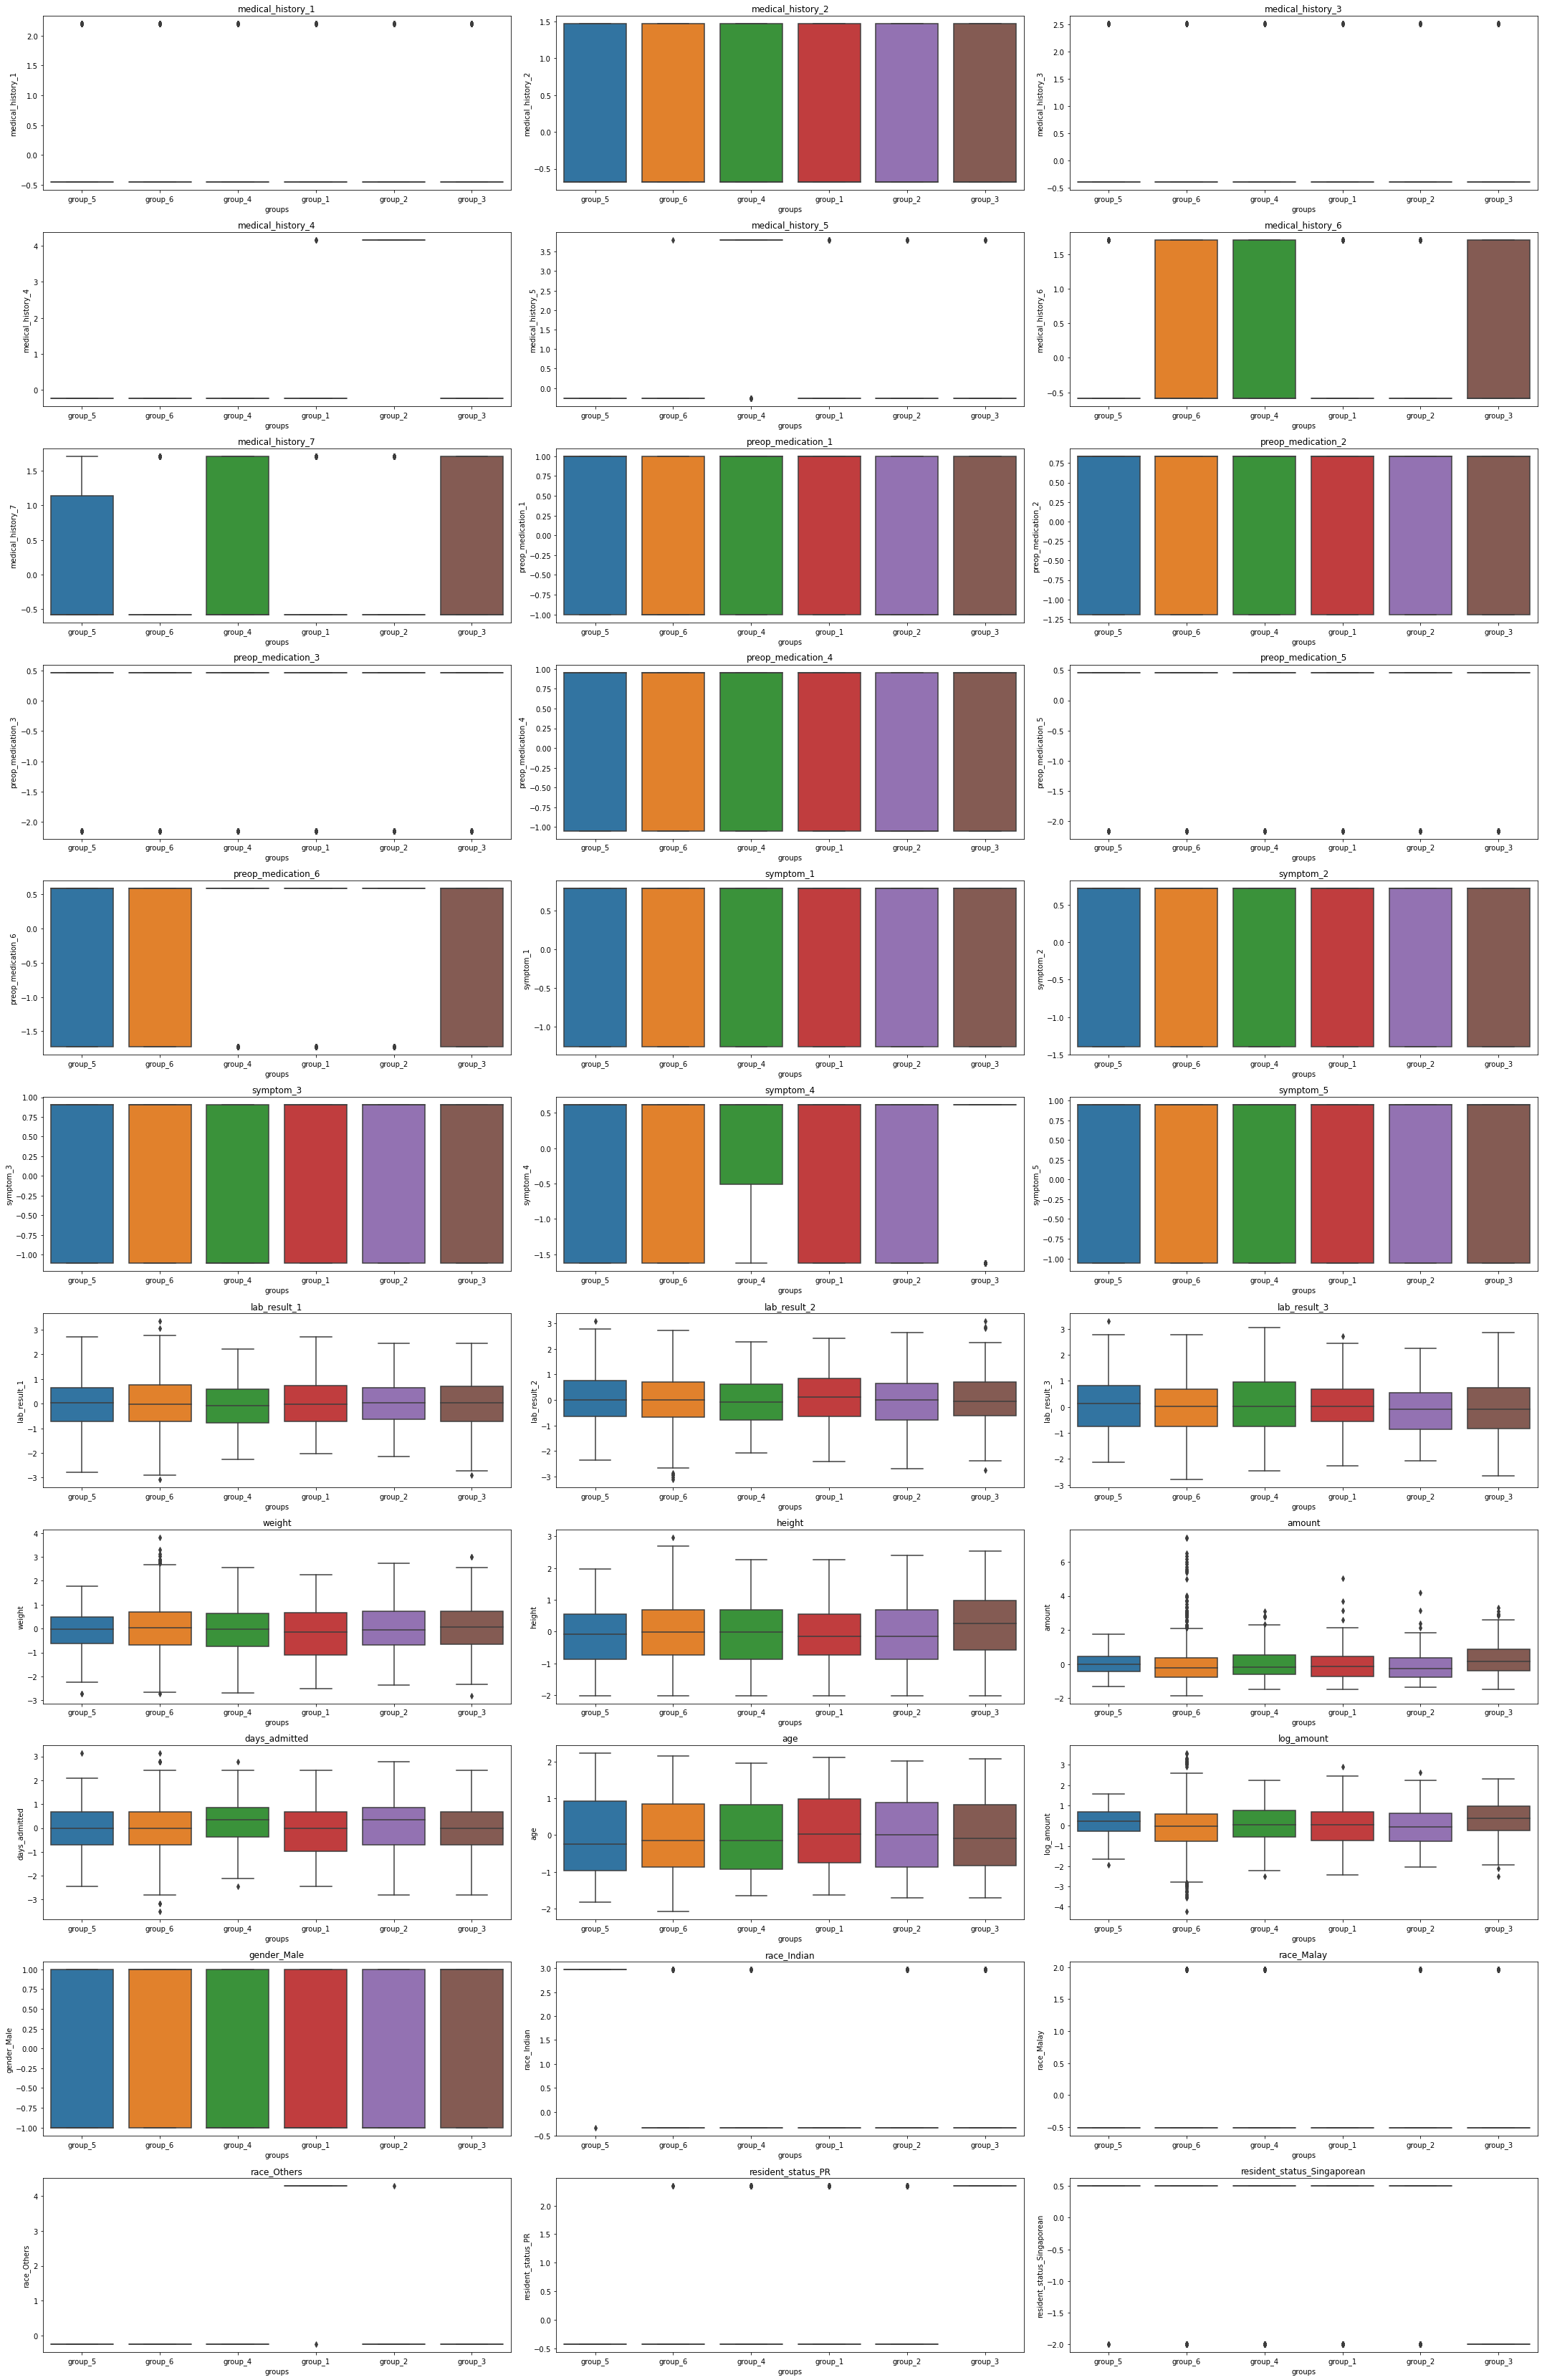

In [87]:
all_col = data_scaled.columns.tolist()
plt.figure(figsize=(30, 50))

for i, variable in enumerate(all_col):
    plt.subplot(12, 3, i + 1)
    sns.boxplot(y=data_scaled[variable], x=data_tsne['groups'])
    plt.tight_layout()
    plt.title(variable)
plt.show()

**Groupings by resident status and race:**
- Group 1: Mostly from race_Others from Singapore
- Group 2: Mostly Singaporean Chinese
- Group 3: PR residents, mostly Chinese
- Group 4: Mostly Singaporean Chinese
- Group 5: Mostly Singaporean Indians
- Group 6: Mostly Singaporean Chinese

**Other properties of groups:**
- Group 1: No `medical_history_6`
- Group 2: `medical_history_4`, no `medical_history_6`
- Group 3: `symptom_4`
- Group 4: `medical_history_5`
- Group 5: No `medical_history_6`
- Group 6: Largest variance in `weight`, `height`, `amount` and `days_admitted`

<AxesSubplot:>

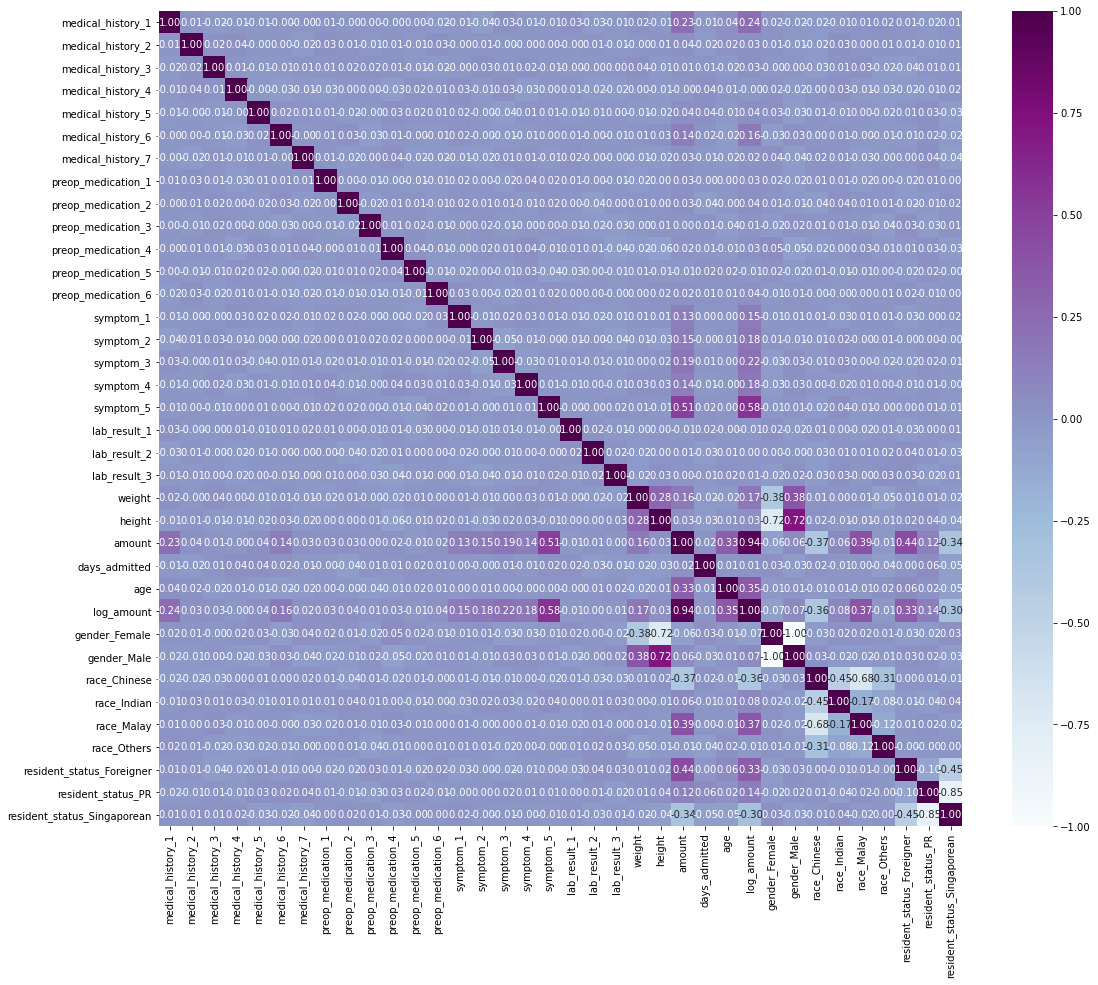

In [88]:
X_corr = data
X_corr = pd.get_dummies(X_corr, drop_first=False)
fig= plt.figure(figsize=(18, 15))
sns.heatmap(X_corr.corr(), annot=True, fmt='0.2f', cmap='BuPu')

- Features with high positive correlation (> 0.3):
    * `symptom_5`
    * `age`
    * `race_Malay`
    * `resident_status_Foreigner`
- Features with high negative correlation (<-0.3):
    * `race_Chinese`
    * `resident_status_Singaporean`
- **Conclusions from EDA and Dimensionality Reduction**
    * PCA reveals that `symptom_5` and `resident_status_Singaporean` are the two most important features in predicting `amount`
    * Bivariate analysis shows that race and resident status are important features: `race_Malay` and `resident_status_Foreigner` tend to have higher `amount`
    * Correlation heatmap shows that `age` is also another important feature and the scatterplot shows that `amount` generally increases as `age` increases

## Section 4: Linear Regression

In [89]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [90]:
def scale(x):
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    x_scaled = pd.DataFrame(x_scaled, index=x.index, columns=x.columns)
    return x_scaled

In [91]:
def get_model_score(model, x, y, value=False):
    y_pred = model.predict(x)
    #print('Coefficients: ', lm.coef_)
    
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    if value==False:
        print('MAE: %.3f' %mae)
        print('RMSE: %.3f' %rmse)
        print('R2 score: ' '%.3f' %r2)
    else:
        return r2

In [92]:
X = data.drop(['amount', 'log_amount'], axis=1)
X.describe(include=['object'])

gender     race resident_status
count    2898     2898            2898
unique      2        4               3
top      Male  Chinese     Singaporean
freq     1454     1855            2315

In [93]:
X = pd.get_dummies(X, drop_first=True)
y = data[['log_amount']]
features = [col for col in X.columns]
output = [col for col in y.columns]

<AxesSubplot:>

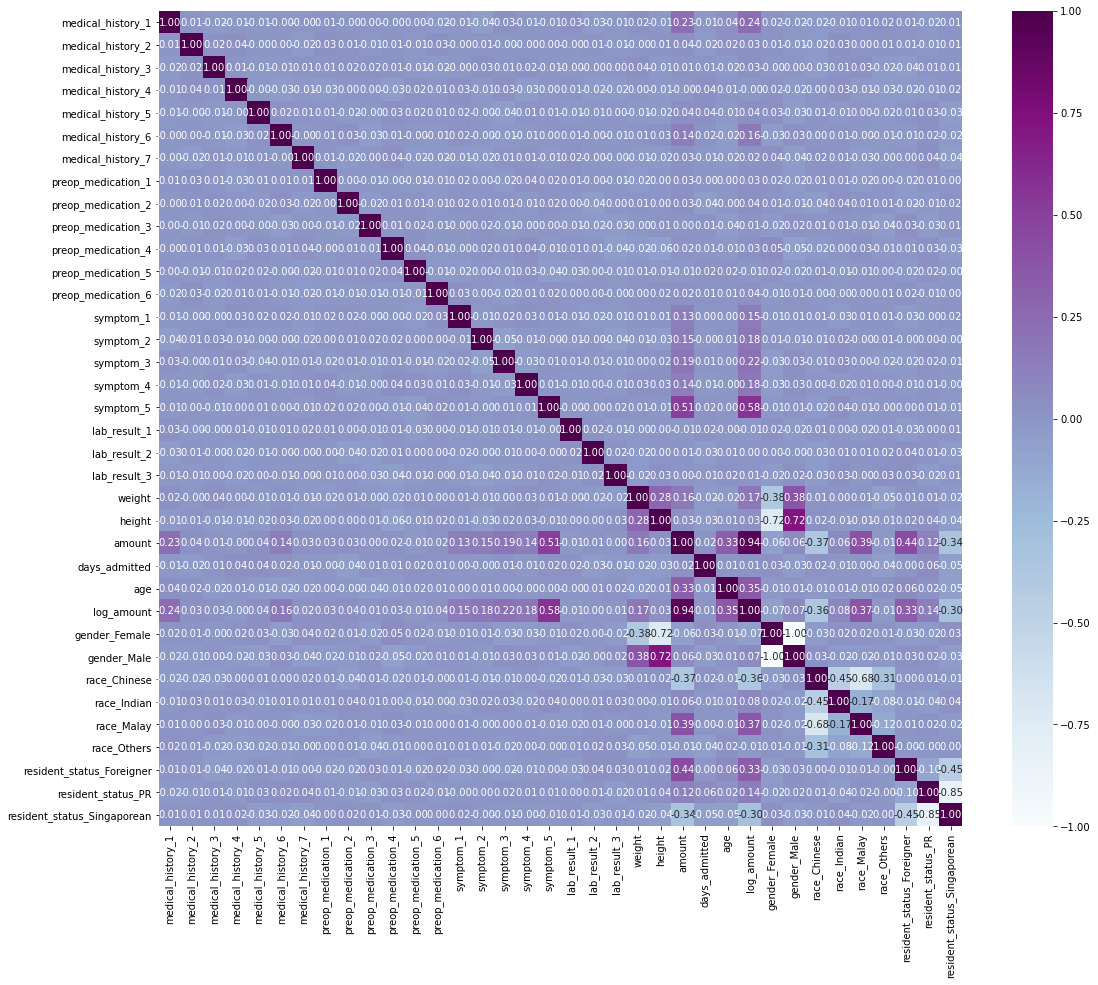

In [94]:
X_corr = data
X_corr = pd.get_dummies(X_corr, drop_first=False)
fig= plt.figure(figsize=(18, 15))
sns.heatmap(X_corr.corr(), annot=True, fmt='0.2f', cmap='BuPu')

In [95]:
#Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2028, 31) (870, 31) (2028, 1) (870, 1)


In [96]:
lm1 = LinearRegression().fit(scale(X_train), y_train)

In [97]:
get_model_score(lm1, scale(X_train), y_train)

MAE: 0.051
RMSE: 0.071
R2 score: 0.975


In [98]:
X_train_scaled_1 = sm.add_constant(scale(X_train))
ols_model_1 = sm.OLS(y_train, X_train_scaled_1)
ols_res_1 = ols_model_1.fit()

In [99]:
print(ols_res_1.summary())

                            OLS Regression Results                            
Dep. Variable:             log_amount   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2519.
Date:                Mon, 23 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:02:17   Log-Likelihood:                 2477.7
No. Observations:                2028   AIC:                            -4891.
Df Residuals:                    1996   BIC:                            -4712.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [100]:
features_non_sig = []
for i in range(0,len(X_train_scaled_1.columns)):
    if(ols_res_1.pvalues[i]>0.05):
        features_non_sig.append(X_train_scaled_1.columns[i])
        
X_train_scaled_2 = X_train_scaled_1.drop(features_non_sig,axis=1)
features_lr = [col for col in X_train_scaled_2.columns]
features_lr

['const',
 'medical_history_1',
 'medical_history_2',
 'medical_history_3',
 'medical_history_5',
 'medical_history_6',
 'medical_history_7',
 'preop_medication_1',
 'preop_medication_2',
 'preop_medication_3',
 'preop_medication_5',
 'preop_medication_6',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5',
 'weight',
 'height',
 'age',
 'race_Indian',
 'race_Malay',
 'race_Others',
 'resident_status_PR',
 'resident_status_Singaporean']

In [152]:
len(features_lr)

24

In [101]:
X_train_scaled_2 = sm.add_constant(X_train_scaled_2)
ols_model_2 = sm.OLS(y_train, X_train_scaled_2)
ols_res_2 = ols_model_2.fit()

In [102]:
print(ols_res_2.summary())

                            OLS Regression Results                            
Dep. Variable:             log_amount   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     3249.
Date:                Mon, 23 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:02:17   Log-Likelihood:                 2472.8
No. Observations:                2028   AIC:                            -4896.
Df Residuals:                    2003   BIC:                            -4755.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## Tests for Model Assumptions

**Part 1: No multicolliinearity among independent variables**
- We will test for presence of multi-collinearity using Variation Inflation Factor.

- Variance Inflation factor: Variance inflation factors measures the inflation in the variances of the regression parameter estimates due to collinearities that exist among the predictors. It is a measure of how much the variance of the estimated regression coefficient βk is “inflated” by the existence of correlation among the predictor variables in the model.

- General Rule of thumb: If VIF is 1 then there is no correlation among the kth predictor and the remaining predictor variables, and hence the variance of β̂k is not inflated at all. Whereas if VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity.

In [103]:
vif_series_1 = pd.Series([variance_inflation_factor(X_train_scaled_2.values,i) for i in range(X_train_scaled_2.shape[1])],
                        index=X_train_scaled_2.columns)

print('Series before feature selection: \n\n{}\n'.format(vif_series_1))

Series before feature selection: 

const                          62.510179
medical_history_1               1.008614
medical_history_2               1.009467
medical_history_3               1.008865
medical_history_5               1.007166
medical_history_6               1.012456
medical_history_7               1.009691
preop_medication_1              1.010333
preop_medication_2              1.007537
preop_medication_3              1.010013
preop_medication_5              1.008791
preop_medication_6              1.009347
symptom_1                       1.008424
symptom_2                       1.012807
symptom_3                       1.014678
symptom_4                       1.014100
symptom_5                       1.008858
weight                          1.090126
height                          1.092312
age                             1.016188
race_Indian                     1.054027
race_Malay                      1.057452
race_Others                     1.031666
resident_status_PR    

- **Conclusion**: VIF is less than 5 for all features and we can conclude that there is no multicollinearity between them

**Part 2: Test for mean of residuals**

In [104]:
residual = ols_res_2.resid
residual.mean()

-1.1470903122831233e-13

- **Conclusion**: The mean of residuals is very close to zero and therefore this condition is satisfied

**Part 3: Test for normality of residuals**

<AxesSubplot:ylabel='Count'>

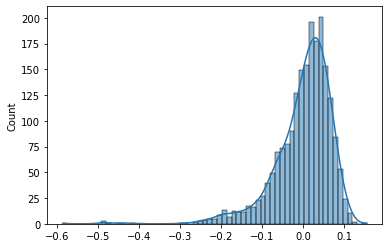

In [105]:
sns.histplot(residual, kde=True)

- **Conclusion**: The residuals are normally distributed and therefore this condition is satisfied

**Part 4: Test for linearity of residuals**

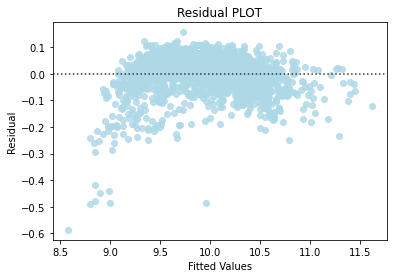

In [106]:
fitted = ols_res_2.fittedvalues
sns.residplot(x = fitted, y = residual, color="lightblue")
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

- **Conclusion**: The residuals are linearly related to the dependent variable and therefore this condition is satisfied.

**Part 5: Test for homoskedasticity**

In [107]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(y_train, X_train_scaled_2)
lzip(name, test)

[('F statistic', 1.105847694539696), ('p-value', 0.05690341663849414)]

- **Conclusion**: p-value > 0.05 and thus this condition is satisfied

In [108]:
del features_lr[0]

In [109]:
lm2 = LinearRegression().fit(scale(X_train[features_lr]), y_train)

In [110]:
get_model_score(lm2, scale(X_train[features_lr]), y_train)

MAE: 0.051
RMSE: 0.071
R2 score: 0.975


In [111]:
get_model_score(lm2, scale(X_test[features_lr]), y_test)

MAE: 0.063
RMSE: 0.082
R2 score: 0.966


- All the assumptions of the linear regression model are fulfilled
- The linear regression model performs well on both training and test data
- The model has the following significant features:
    * `medical_history_1` 
    * `medical_history_2` 
    * `medical_history_3` 
    * `medical_history_5` 
    * `medical_history_6` 
    * `medical_history_7`
    * `preop_medication_1` 
    * `preop_medication_2` 
    * `preop_medication_3` 
    * `preop_medication_5` 
    * `preop_medication_6` 
    * `symptom_1`
    * `symptom_2`
    * `symptom_3`
    * `symptom_4`
    * `symptom_5`
    * `weight`
    * `height`
    * `age`
    * `race_Indian`
    * `race_Malay`
    * `race_Others`
    * `resident_status_PR`
    * `resident_status_Singaporean`

In [112]:
from sklearn.model_selection import cross_val_score

linearregression = LinearRegression() 
cv_Score11 = cross_val_score(linearregression, X_train[features_lr], y_train, cv = 10)
cv_Score12 = cross_val_score(linearregression, X_train[features_lr], y_train, cv = 10, 
                             scoring = 'neg_mean_squared_error') 


print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std() * 2))
print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1*cv_Score12.mean(), cv_Score12.std() * 2))

RSquared: 0.974 (+/- 0.008)
Mean Squared Error: 0.005 (+/- 0.002)


- Cross Validation score re-affirms that the model fits the data well and is not overfitting

In [113]:
ols_res_2.params

const                          9.042985
medical_history_1              0.271152
medical_history_2              0.018438
medical_history_3              0.026202
medical_history_5              0.055615
medical_history_6              0.165408
medical_history_7              0.043251
preop_medication_1             0.023020
preop_medication_2             0.016316
preop_medication_3             0.031064
preop_medication_5             0.015945
preop_medication_6             0.024734
symptom_1                      0.132138
symptom_2                      0.181439
symptom_3                      0.196815
symptom_4                      0.170542
symptom_5                      0.505591
weight                         0.406015
height                        -0.040584
age                            0.613062
race_Indian                    0.191723
race_Malay                     0.443513
race_Others                    0.098340
resident_status_PR            -0.509460
resident_status_Singaporean   -0.692331


In [114]:
abs(ols_res_2.tvalues).sort_values(ascending=False)

const                          716.084816
symptom_5                      157.175372
race_Malay                     109.709430
age                             89.553351
resident_status_Singaporean     89.083998
medical_history_1               65.146197
symptom_3                       60.775614
resident_status_PR              59.649340
symptom_2                       53.478708
symptom_4                       47.191400
medical_history_6               45.024338
weight                          41.337696
symptom_1                       39.919608
race_Indian                     35.621665
race_Others                     12.416603
medical_history_7               11.729635
medical_history_5                8.707759
preop_medication_3               7.402448
preop_medication_1               7.168935
preop_medication_6               6.674159
medical_history_3                5.591587
medical_history_2                5.339562
preop_medication_2               4.984265
height                           4

- The top 5 significant features of the linear regression model are:
    * `symptom_5`
    * `race_Malay`
    * `age`
    * `resident_status_Singaporean`
    * `medical_history_1`

In [115]:
ols_res_2.conf_int()

0         1
const                        9.018219  9.067751
medical_history_1            0.262990  0.279315
medical_history_2            0.011666  0.025210
medical_history_3            0.017012  0.035392
medical_history_5            0.043089  0.068140
medical_history_6            0.158203  0.172613
medical_history_7            0.036020  0.050482
preop_medication_1           0.016723  0.029318
preop_medication_2           0.009896  0.022735
preop_medication_3           0.022834  0.039294
preop_medication_5           0.007841  0.024049
preop_medication_6           0.017466  0.032001
symptom_1                    0.125646  0.138630
symptom_2                    0.174786  0.188093
symptom_3                    0.190464  0.203166
symptom_4                    0.163454  0.177629
symptom_5                    0.499282  0.511899
weight                       0.386753  0.425278
height                      -0.056827 -0.024341
age                          0.599637  0.626488
race_Indian                  0.181167  0.202278
race_Malay                   0.435585  0.451441
race_Others                  0.082807  0.113872
resident_status_PR          -0.526210 -0.492710
resident_status_Singaporean -0.707572 -0.677090

## Section 5: Decision Tree Regressor

In [116]:
dtree = DecisionTreeRegressor(random_state=1)
dtree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [117]:
dtree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [118]:
get_model_score(dtree, X_train, y_train)

MAE: 0.000
RMSE: 0.000
R2 score: 1.000


In [119]:
get_model_score(dtree, X_test, y_test)

MAE: 0.162
RMSE: 0.216
R2 score: 0.762


In [120]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(dtree, X_train, y_train, cv =10)
print(score.mean())

0.7428514481266044


In [148]:
prediction_importance = list(dtree.feature_importances_)
input_importance = [(feature, importance) for feature, importance in zip(features, prediction_importance)]

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

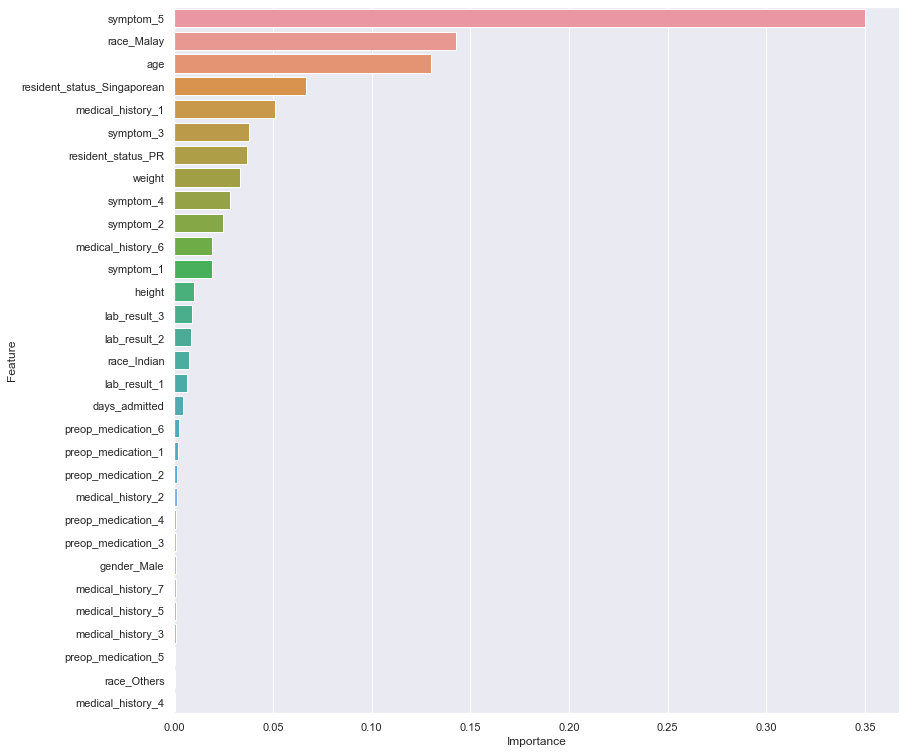

In [149]:
sorted_inputs = sorted(input_importance, key=lambda tup: tup[1], reverse=True)
plt.figure(figsize=(13,13))
importance_df = pd.DataFrame(sorted_inputs, columns = ["Feature", "Importance"])
sns.barplot(importance_df.Importance,importance_df.Feature)

#print(pd.DataFrame(sorted_inputs, columns = ["Feature", "Importance"]).iloc[0:20])

In [150]:
len(importance_df[importance_df["Importance"]>0].Feature[:])

31

In [123]:
dt1 = DecisionTreeRegressor(random_state=1)
dt1.fit(X_train, y_train)
path=dt1.cost_complexity_pruning_path(X_train, y_train)
alphas=path['ccp_alphas']
len(alphas)

1990

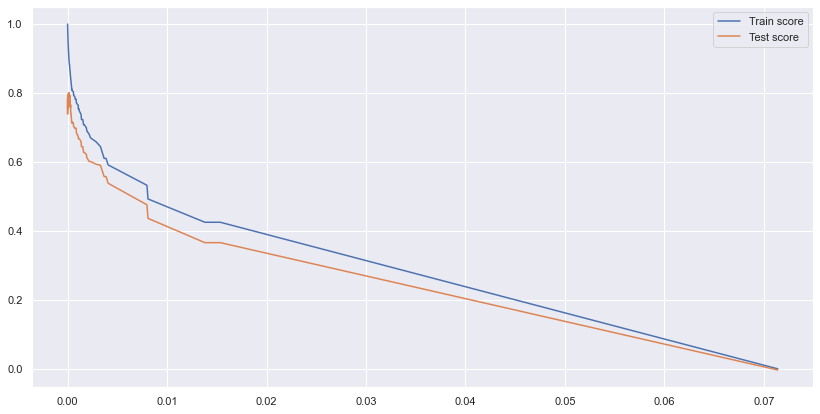

In [124]:
train_scores = []
test_scores = []
for a in alphas:
    dt1 = DecisionTreeRegressor(ccp_alpha=a)
    dt1.fit(X_train, y_train)
    train_scores.append(get_model_score(dt1, X_train, y_train, value=True))
    test_scores.append(get_model_score(dt1, X_test, y_test, value=True))
    
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=train_scores, x=alphas, label="Train score")
sns.lineplot(y=test_scores, x=alphas, label="Test score")
plt.show()

In [125]:
alpha_max = 0
test_score = 0

for i in range(0,1990):
    dt1 = DecisionTreeRegressor(ccp_alpha=sorted(alphas)[i])
    dt1.fit(X_train, y_train)
    if get_model_score(dt1, X_test, y_test, value=True) > test_score:
        test_score = get_model_score(dt1, X_test, y_test, value=True)
        alpha_max = i
        
print(alpha_max)

1894


In [139]:
dt1 = DecisionTreeRegressor(ccp_alpha=sorted(alphas)[1894])
dt1.fit(X_train, y_train)
get_model_score(dt1, X_train, y_train)

MAE: 0.117
RMSE: 0.148
R2 score: 0.893


In [140]:
get_model_score(dt1, X_test, y_test)

MAE: 0.154
RMSE: 0.200
R2 score: 0.797


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

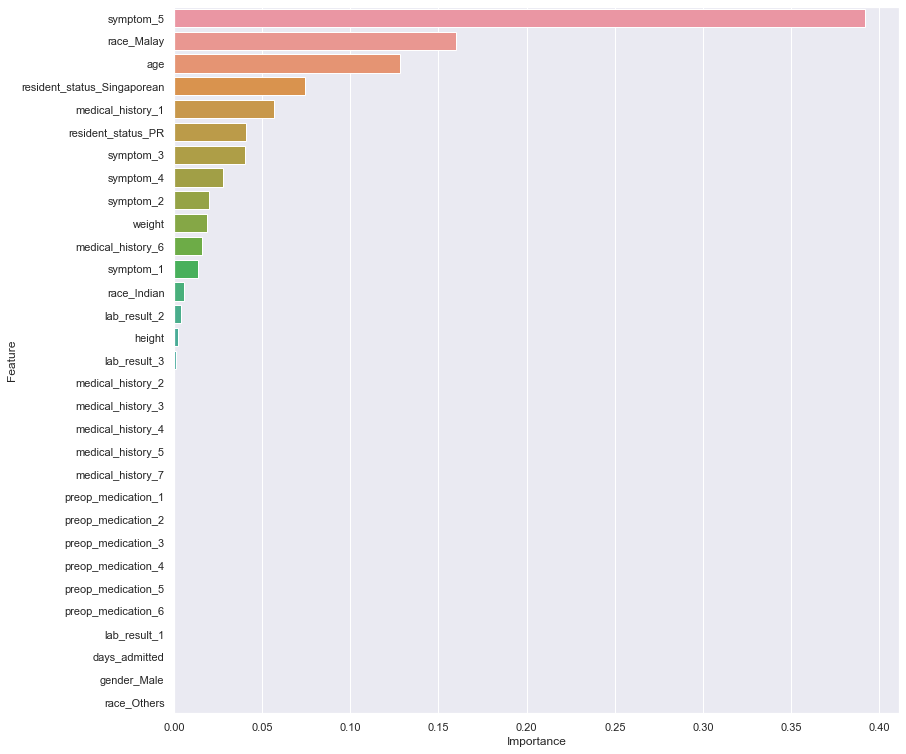

In [142]:
prediction_importance = list(dt1.feature_importances_)
input_importance = [(feature, importance) for feature, importance in zip(features, prediction_importance)]
sorted_inputs = sorted(input_importance, key=lambda tup: tup[1], reverse=True)
plt.figure(figsize=(13,13))
importance_df = pd.DataFrame(sorted_inputs, columns = ["Feature", "Importance"])
sns.barplot(importance_df.Importance,importance_df.Feature)

In [143]:
len(importance_df[importance_df["Importance"]>0].Feature[:])

16

- The top 5 significant features of the tuned decision tree model are:
    * `symptom_5`
    * `race_Malay`
    * `age`
    * `resident_status_Singaporean`
    * `medical_history_1`
- These are the same as the linear regression model

## Section 6: Random Forest Regressor

In [145]:
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [130]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [131]:
get_model_score(rf, X_train, y_train)

MAE: 0.041
RMSE: 0.056
R2 score: 0.985


In [132]:
get_model_score(rf, X_test, y_test)

MAE: 0.113
RMSE: 0.155
R2 score: 0.877


In [133]:
score = cross_val_score(rf, X_train, y_train, cv=10)
print(score.mean())  

0.8888054383555959


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

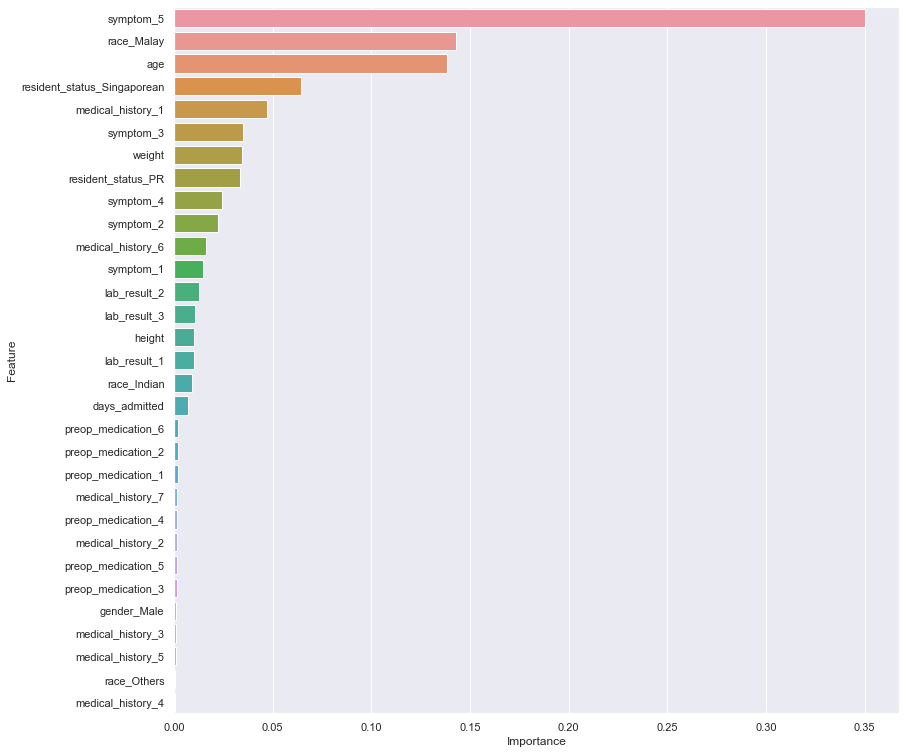

In [146]:
prediction_importance = list(rf.feature_importances_)
input_importance = [(feature, importance) for feature, importance in zip(features, prediction_importance)]
sorted_inputs = sorted(input_importance, key=lambda tup: tup[1], reverse=True)
plt.figure(figsize=(13,13))
importance_df = pd.DataFrame(sorted_inputs, columns = ["Feature", "Importance"])
sns.barplot(importance_df.Importance,importance_df.Feature)

In [147]:
len(importance_df[importance_df["Importance"]>0].Feature[:])

31

In [135]:
param_grid = {
    'bootstrap': [True],
    'min_samples_leaf': [2,4],
    'min_samples_split': [2,4,6],
    'n_estimators': [1600, 1800, 2000]
}

rf = RandomForestRegressor(random_state=1, oob_score=True)
scorer = metrics.make_scorer(metrics.r2_score)
gridCV = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2)
gridCV = gridCV.fit(X_train, y_train)
rf_tuned = gridCV.best_estimator_
rf_tuned.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


RandomForestRegressor(min_samples_leaf=2, n_estimators=1800, oob_score=True,
                      random_state=1)

In [136]:
get_model_score(rf_tuned, X_train, y_train)

MAE: 0.046
RMSE: 0.064
R2 score: 0.980


In [137]:
get_model_score(rf_tuned, X_test, y_test)

MAE: 0.111
RMSE: 0.153
R2 score: 0.881


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

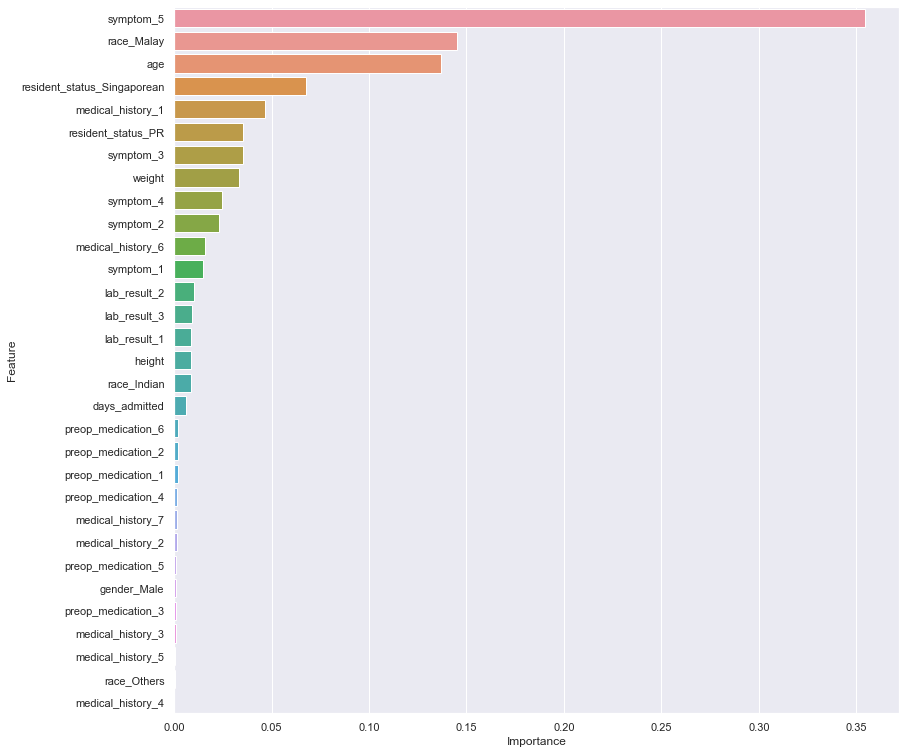

In [138]:
prediction_importance = list(rf_tuned.feature_importances_)
input_importance = [(feature, importance) for feature, importance in zip(features, prediction_importance)]
sorted_inputs = sorted(input_importance, key=lambda tup: tup[1], reverse=True)
plt.figure(figsize=(13,13))
importance_df = pd.DataFrame(sorted_inputs, columns = ["Feature", "Importance"])
sns.barplot(importance_df.Importance,importance_df.Feature)

In [141]:
len(importance_df[importance_df["Importance"]>0].Feature[:])

31

- The top 5 significant features of the tuned random forest model are:
    * `symptom_5`
    * `race_Malay`
    * `age`
    * `resident_status_Singaporean`
    * `medical_history_1`
- These are the same as the linear regression model